# EDA Summary

1. In the given dataset we have 8 categorical features and 369 numerical features.
2. Scatter plot,PDF and CDF for Y target variable showed most values lie between 80 and 140. There are 99% values below 150 and 150 is taken as threshold for target variable.
5. Using Scatter plot on ID vs Target variable showed ID does not have much impact on target. So ID was removed from the dataset.
4. Using Seaborn and Matplot libraries to plot Bar and Scatter plots for Categorical varibales. There were some outliers present in the dataset.
5. Found that the feature X4 has the lowest variance among categorical variables, so it was removed from the datset.
6. There are 12 features which had same value across the dataset when analysing numerical features. These 12 features are removed from the dataset.
5. Used Recursive Feature Elimination to select top features from Numerical Features and created a heatmap using correlation. There were some columns which exhibited multicollinearity. So the Multicollinear columns was removed from dataset.
6. Used Random Forests on Numerical data to get top features which have more impact on y. 

# FE Summary

1. The final dataset from EDA had 318 columns total.
2. Created Correlation features from the top features i got from Random forest model.
3. Used Elbow method to select the optimum number of features for PCA. Created PCA features fpr Numerical columns of our dataset.
4. Used Thresholding of singluar values (https://arxiv.org/pdf/1305.5870.pdf) paper to get optimum rank for creating TSVD features. Created TSVD features based on the optimum rank for Numerical columns of our dataset.
5. For categorical features, I have used Label Encoding, Mean Encoding and GLMM Encoding and created datasets.
6. For every type of Encoding I created below three types of datasets

    <p>Encoding + Interaction features<p>
    <p>Encoding + Interaction + PCA features<p>
    <p>Encoding + Interaction + TSVD features<p>

# Models

In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedKFold,RepeatedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
test_id = pd.read_csv('test.csv')
test_id = test_id[['ID']]

In [3]:
# Train file saved from EDA
train_org = pd.read_csv('preprocessed_train.csv')

In [4]:
y_train = train_org[['y']]

## Importing data

##### This is normalized data and consists of label encoding of categorical features with interaction features added to original train.

In [5]:
label_interaction_train = pd.read_csv('label_encoding/preprocessed_train_label_interaction.csv')
label_interaction_test = pd.read_csv('label_encoding/preprocessed_test_label_interaction.csv')

##### This is normalized data and consists of label encoding of categorical features with interaction features , PCA features added to original train.

In [6]:
label_interaction_pca_train = pd.read_csv('label_encoding/train_label_interaction_pca.csv')
label_interaction_pca_test = pd.read_csv('label_encoding/test_label_interaction_pca.csv')

##### This is normalized data and consists of label encoding of categorical features, interaction features, TSVD features added to original train.

In [7]:
label_interaction_tsvd_train = pd.read_csv('label_encoding/train_label_interaction_tsvd.csv')
label_interaction_tsvd_test = pd.read_csv('label_encoding/test_label_interaction_tsvd.csv')

##### This is normalized data and consists of mean encoding of categorical features with interaction features added to original train.

In [9]:
mean_interaction_train = pd.read_csv('mean_encoding/preprocessed_train_mean_interaction.csv')
mean_interaction_test = pd.read_csv('mean_encoding/preprocessed_test_mean_interaction.csv')

##### This is normalized data and consists of mean encoding of categorical features, interaction features, PCA features added to original train.

In [10]:
mean_interaction_pca_train = pd.read_csv('mean_encoding/train_mean_interaction_pca.csv')
mean_interaction_pca_test = pd.read_csv('mean_encoding/test_mean_interaction_pca.csv')

##### This is normalized data and consists of mean encoding of categorical features, interaction features, TSVD features added to original train.

In [11]:
mean_interaction_tsvd_train = pd.read_csv('mean_encoding/train_mean_interaction_tsvd.csv')
mean_interaction_tsvd_test = pd.read_csv('mean_encoding/test_mean_interaction_tsvd.csv')

##### This is normalized data and consists of glmm encoding of categorical features with interaction features added to original train.

In [13]:
glmm_interaction_train = pd.read_csv('glmm_encoding/preprocessed_train_glmm_interaction.csv')
glmm_interaction_test = pd.read_csv('glmm_encoding/preprocessed_test_glmm_interaction.csv')

##### This is normalized data and consists of glmm encoding of categorical features, interaction features, PCA features added to original train.

In [14]:
glmm_interaction_pca_train = pd.read_csv('glmm_encoding/train_glmm_interaction_pca.csv')
glmm_interaction_pca_test = pd.read_csv('glmm_encoding/test_glmm_interaction_pca.csv')

##### This is normalized data and consists of glmm encoding of categorical features, interaction features, TSVD features added to original train.

In [15]:
glmm_interaction_tsvd_train = pd.read_csv('glmm_encoding/train_glmm_interaction_tsvd.csv')
glmm_interaction_tsvd_test = pd.read_csv('glmm_encoding/test_glmm_interaction_tsvd.csv')

In [17]:
# Using bins to do stratfied K fold on the dataset.
bins = []
for i in y_train.values:
    if i >70 and i<=90:
        bins.append('a')
    elif i >90 and i<=110:
        bins.append('b')
    elif i>110 and i<= 130:
        bins.append('c')
    elif i>130 and i<=160:
        bins.append('d')

In [18]:
bins = pd.DataFrame(bins,columns = ['bin'])

In [19]:
skf = StratifiedKFold(n_splits=10)
cv_indices = []
for train,test in skf.split(train_org,bins):
    cv_indices.append((train,test))

## GridSearchCV

In [20]:
# Hyperparamter tuning for linear regression models using gridsearch cv and plotting the Train, CV scores
def Lr_model(model,params,x_train):
    grid_model = GridSearchCV(model,params,return_train_score = True,cv = cv_indices,scoring = 'r2')
    grid_model.fit(x_train,y_train)
    #https://matthewbilyeu.com/blog/2019-02-05/validation-curve-plot-from-gridsearchcv-results
    scores_df = pd.DataFrame(grid_model.cv_results_)
    train_scores = scores_df['mean_train_score']
    cv_scores = scores_df['mean_test_score']
    plt.figure(figsize = (10,5))
    plt.plot(np.log10(param['alpha']),train_scores,label = 'Train scores')
    plt.plot(np.log10(param['alpha']),cv_scores,label = 'CV Scores')
    plt.scatter(np.log10(param['alpha']),train_scores)
    plt.scatter(np.log10(param['alpha']),cv_scores)
    plt.xlabel('Log of alphas')
    plt.ylabel('R2 scores')
    plt.grid()
    plt.legend()
    plt.show()
    print('Best R2 score is ', grid_model.best_score_, 'and best hyperparameters is ',grid_model.best_params_)
    return grid_model

## RandomizedSearchCV

In [21]:
# Hyper parameter tuning for ensemble models using Random search cv and plotting the Train, CV scores.
def ensemble(model,params,x_train):
    rs_model = RandomizedSearchCV(model,params,return_train_score = True,cv = cv_indices,scoring = 'r2',n_jobs = -1)
    rs_model.fit(x_train,y_train['y'].values)
    #https://matthewbilyeu.com/blog/2019-02-05/validation-curve-plot-from-gridsearchcv-results
    scores_df = pd.DataFrame(rs_model.cv_results_)
    train_scores = scores_df['mean_train_score']
    cv_scores = scores_df['mean_test_score']
    fold = list(range(1,11))
    plt.figure(figsize = (10,5))
    plt.plot(fold,train_scores,label = 'Train scores')
    plt.plot(fold,cv_scores,label = 'CV Scores')
    plt.scatter(fold,train_scores)
    plt.scatter(fold,cv_scores)
    plt.xlabel('Folds')
    plt.ylabel('R2 scores')
    plt.grid()
    plt.legend()
    plt.show()
    print('Best R2 score is ', rs_model.best_score_, 'and best hyperparameters is ',rs_model.best_params_)
    return rs_model

In [22]:
#Function which plots the features importances for the best model.
def feature_imp(model,train):
    features = train.columns
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[-20:]
    plt.figure(figsize=(10,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), feature_importance[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [23]:
# Funciton which returns the predicted values of test set in submssion csv format.
def submission(model,x_test):
    y_predicted = model.predict(x_test)
    submission_df = pd.DataFrame()
    submission_df['ID'] = test_id['ID']
    submission_df['y'] = y_predicted
    return submission_df

In [24]:
#Function which saves the models to the folder
def save_model(name,model):
    filename = 'models/'+str(name)+'.sav'
    pickle.dump(model,open(filename,'wb'))

## Datasets 1 (encoding of categorical variables + interaction features)

### Linear Regression Models

#### Label Encoding

In [25]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98564.15484520879, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95787.36007786679, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93232.65688417084, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want 

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51639.06799447375, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6510.700915598805, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5782.382973443659, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want

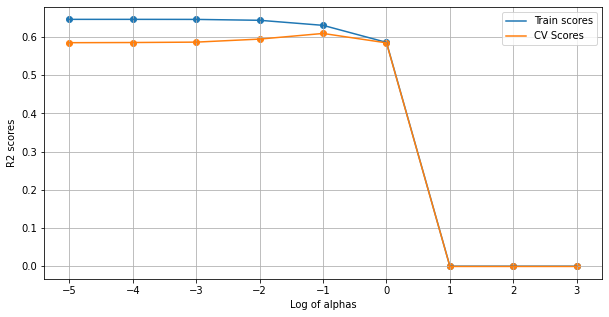

Best R2 score is  0.6093275299477715 and best hyperparameters is  {'alpha': 0.1}


In [26]:
#Hyperparameter tuning of Lasso model
label_corr_lr_model = Lr_model(Lasso(),param,label_interaction_train)

# Best model from the hyperparameter tuning
label_corr_lr_final = label_corr_lr_model.best_estimator_
label_corr_lr_final.fit(label_interaction_train,y_train)

# Final submission.csv for kaggle scores
label_corr_submission = submission(label_corr_lr_final,label_interaction_test)
save_model('label_corr_lr_final',label_corr_lr_final)

In [27]:
label_corr_submission.to_csv('label_submission/label_corr_lasso_submission.csv',index = False)

#### Mean Encoding

In [28]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93065.16172988378, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90268.50146999265, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88001.56591399787, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want 

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53346.95047426199, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(


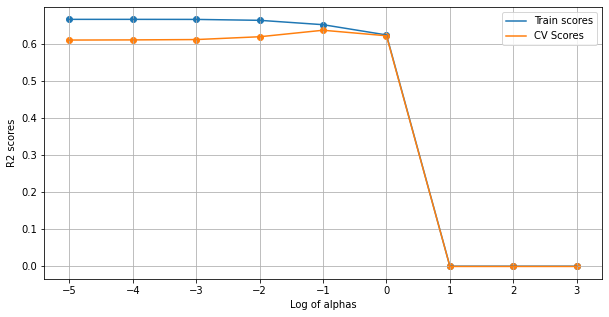

Best R2 score is  0.6362651028623724 and best hyperparameters is  {'alpha': 0.1}


In [29]:
#Hyperparameter tuning of Lasso model
mean_corr_lr_model = Lr_model(Lasso(),param,mean_interaction_train)

# Best model from the hyperparameter tuning
mean_corr_lr_final = mean_corr_lr_model.best_estimator_
mean_corr_lr_final.fit(mean_interaction_train,y_train)

# Final submission.csv for kaggle scores
mean_corr_submission = submission(mean_corr_lr_final,mean_interaction_test)
save_model('mean_corr_lr_final',mean_corr_lr_final)

In [30]:
mean_corr_submission.to_csv('mean_submission/mean_corr_lasso_submission.csv',index = False)

#### GLMM encoding

In [31]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93045.36298939542, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90321.39008270232, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88247.91453352588, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want 

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53789.115530755254, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(


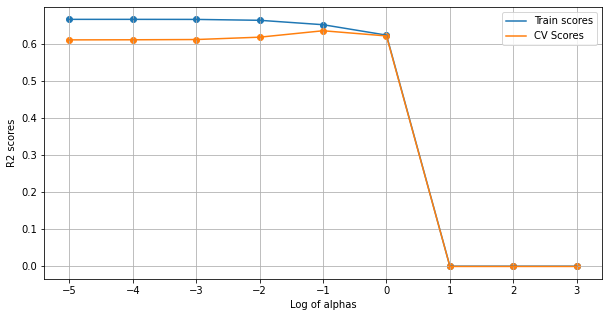

Best R2 score is  0.6348277393211063 and best hyperparameters is  {'alpha': 0.1}


In [32]:
#Hyperparameter tuning of Lasso model
glmm_corr_lr_model = Lr_model(Lasso(),param,glmm_interaction_train)

# Best model from the hyperparameter tuning
glmm_corr_lr_final = glmm_corr_lr_model.best_estimator_
glmm_corr_lr_final.fit(glmm_interaction_train,y_train)

# Final submission.csv for kaggle scores
glmm_corr_submission = submission(glmm_corr_lr_final,glmm_interaction_test)
save_model('glmm_corr_lr_final',glmm_corr_lr_final)

In [33]:
glmm_corr_submission.to_csv('glmm_submission/glmm_corr_lasso_submission.csv',index = False)

### Random Forest Models

#### Label Encoding

In [34]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


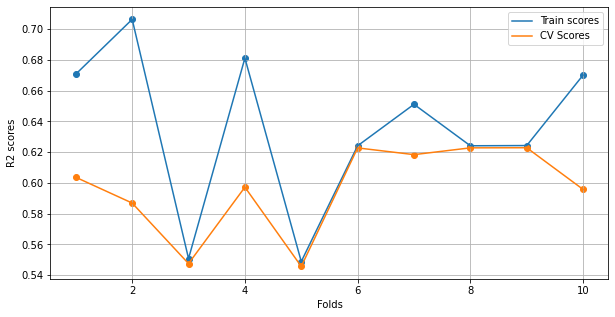

Best R2 score is  0.6228319781611398 and best hyperparameters is  {'n_estimators': 350, 'min_samples_split': 5, 'min_samples_leaf': 6, 'min_impurity_decrease': 1, 'max_features': 0.95, 'max_depth': 7}

Plot representing the feature importances for the best model selected from hyperparameter tuning


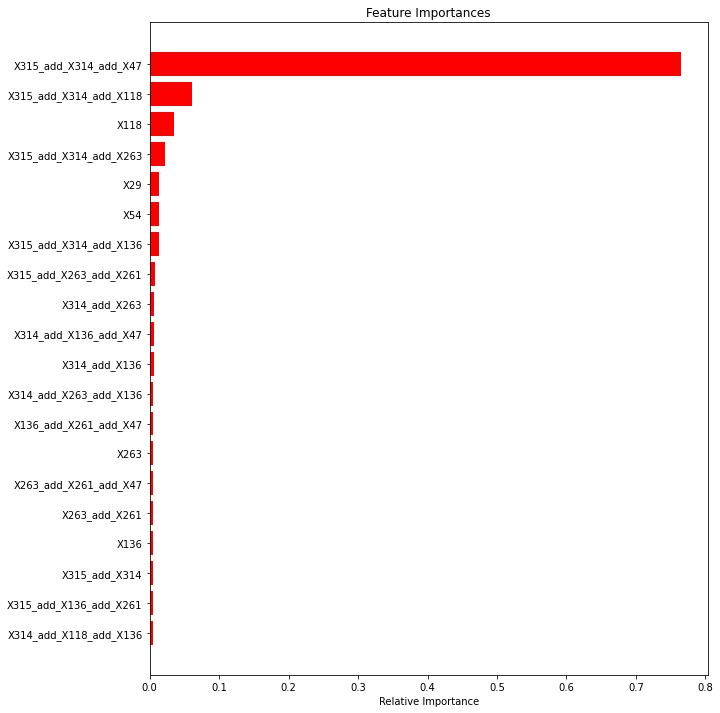

In [35]:
model = RandomForestRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_corr_rf_model = ensemble(model,params,label_interaction_train)

# Best model from the hyperparameter tuning
label_corr_rf_final = label_corr_rf_model.best_estimator_
label_corr_rf_final.fit(label_interaction_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(label_corr_rf_final,label_interaction_train)

# Final submission.csv for kaggle scores
label_corr_submission = submission(label_corr_rf_final,label_interaction_test)
save_model('label_corr_rf_final',label_corr_rf_final)

##### From above feature importances plot we can see that interaction features have high importance than other features.

In [36]:
label_corr_submission.to_csv('label_submission/label_corr_rf_submission.csv',index = False)

#### Mean Encoding

In [37]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


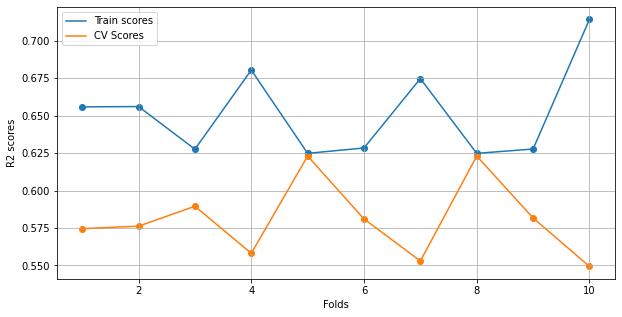

Best R2 score is  0.6229784360276029 and best hyperparameters is  {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.001, 'max_features': 0.95, 'max_depth': 2}

Plot representing the feature importances for the best model selected from hyperparameter tuning


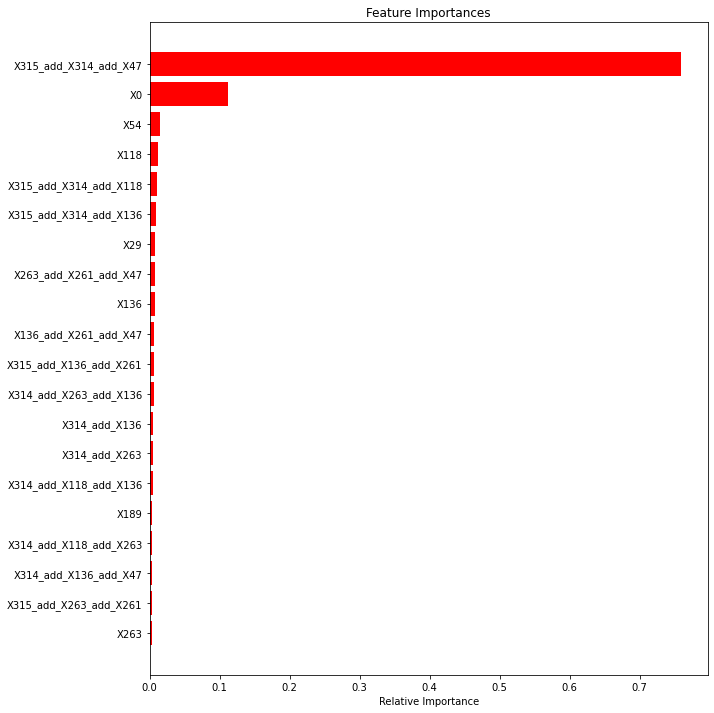

In [38]:
model = RandomForestRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_corr_rf_model = ensemble(model,params,mean_interaction_train)

# Best model from the hyperparameter tuning
mean_corr_rf_final = mean_corr_rf_model.best_estimator_
mean_corr_rf_final.fit(mean_interaction_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(mean_corr_rf_final,mean_interaction_train)

# Final submission.csv for kaggle scores
mean_corr_submission = submission(mean_corr_rf_final,mean_interaction_test)
save_model('mean_corr_rf_final',mean_corr_rf_final)

##### From above feature importances plot we can see that categorical feature X0, interaction features has more importance. There were no categorical features present in label encoding plot.

In [39]:
mean_corr_submission.to_csv('mean_submission/mean_corr_rf_submission.csv',index = False)

#### GLMM Encoding

In [40]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


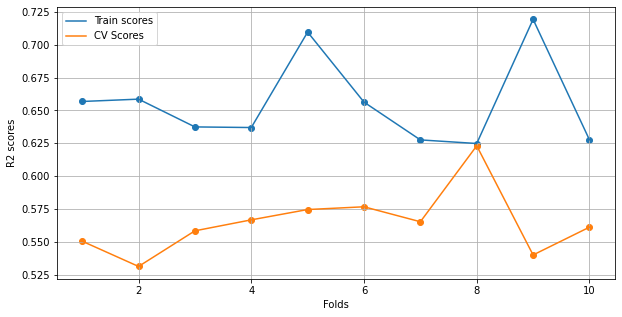

Best R2 score is  0.6230460552270063 and best hyperparameters is  {'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.01, 'max_features': 0.95, 'max_depth': 2}

Plot representing the feature importances for the best model selected from hyperparameter tuning


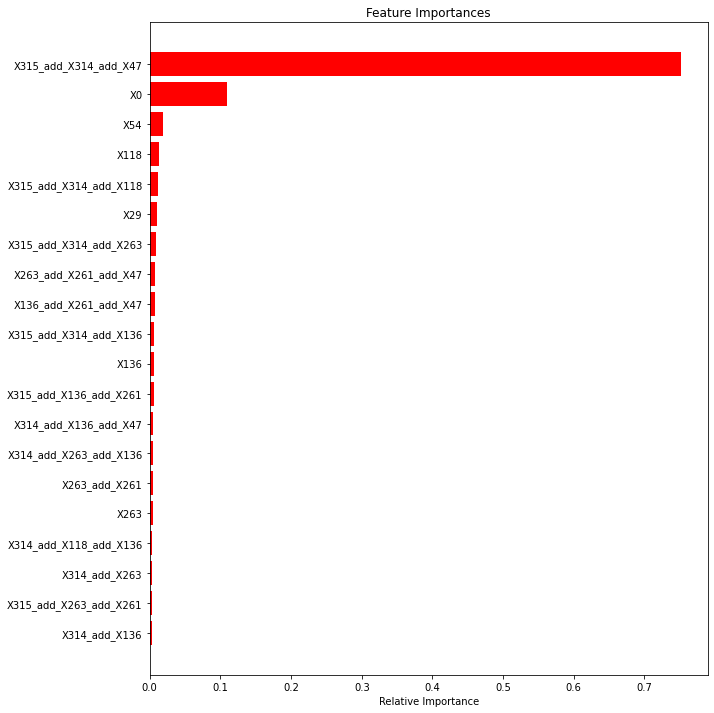

In [41]:
model = RandomForestRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_corr_rf_model = ensemble(model,params,glmm_interaction_train)

# Best model from the hyperparameter tuning
glmm_corr_rf_final = glmm_corr_rf_model.best_estimator_
glmm_corr_rf_final.fit(glmm_interaction_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(glmm_corr_rf_final,glmm_interaction_train)

# Final submission.csv for kaggle scores
glmm_corr_submission = submission(glmm_corr_rf_final,glmm_interaction_test)
save_model('glmm_corr_rf_final',glmm_corr_rf_final)

##### From above feature importances plot we can see that categorical feature X0, interaction features has more importance. There were no categorical features present in label encoding plot.

In [42]:
glmm_corr_submission.to_csv('glmm_submission/glmm_corr_rf_submission.csv',index = False)

### Extratrees Regressor

#### Label Encoding

In [43]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


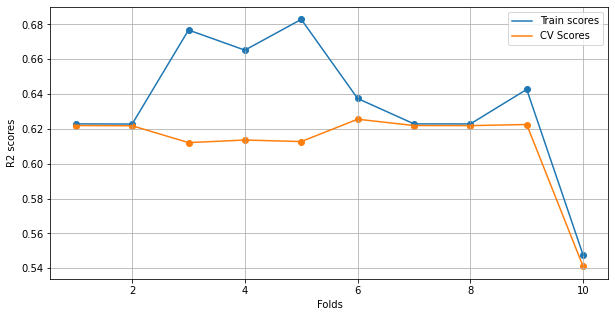

Best R2 score is  0.6255783490831661 and best hyperparameters is  {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.1, 'max_features': 0.95, 'max_depth': 7}

Plot representing the feature importances for the best model selected from hyperparameter tuning


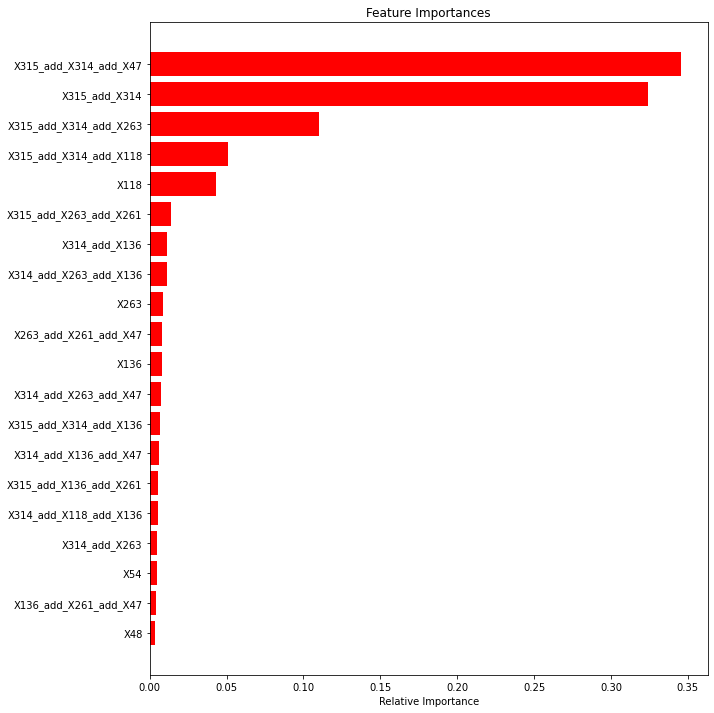

In [44]:
model = ExtraTreesRegressor(random_state = 42,max_features = 0.95,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_corr_et_model = ensemble(model,params,label_interaction_train)

# Best model from the hyperparameter tuning
label_corr_et_final = label_corr_et_model.best_estimator_
label_corr_et_final.fit(label_interaction_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(label_corr_et_final,label_interaction_train)

# Final submission.csv for kaggle scores
label_corr_submission = submission(label_corr_et_final,label_interaction_test)
save_model('label_corr_et_final',label_corr_et_final)

##### From above feature importances plot we can see that top features are interaction features.

In [45]:
label_corr_submission.to_csv('label_submission/label_corr_et_submission.csv',index = False)

#### Mean Encoding

In [46]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


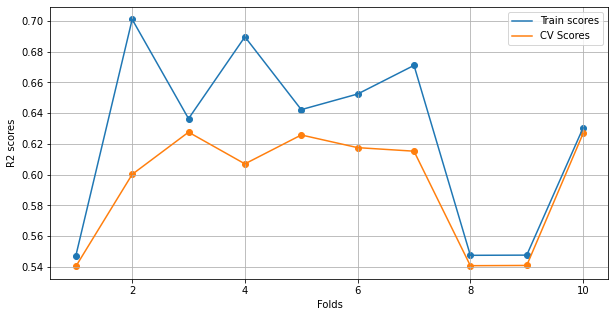

Best R2 score is  0.6276439225358128 and best hyperparameters is  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 7, 'min_impurity_decrease': 1e-05, 'max_features': 0.95, 'max_depth': 4}

Plot representing the feature importances for the best model selected from hyperparameter tuning


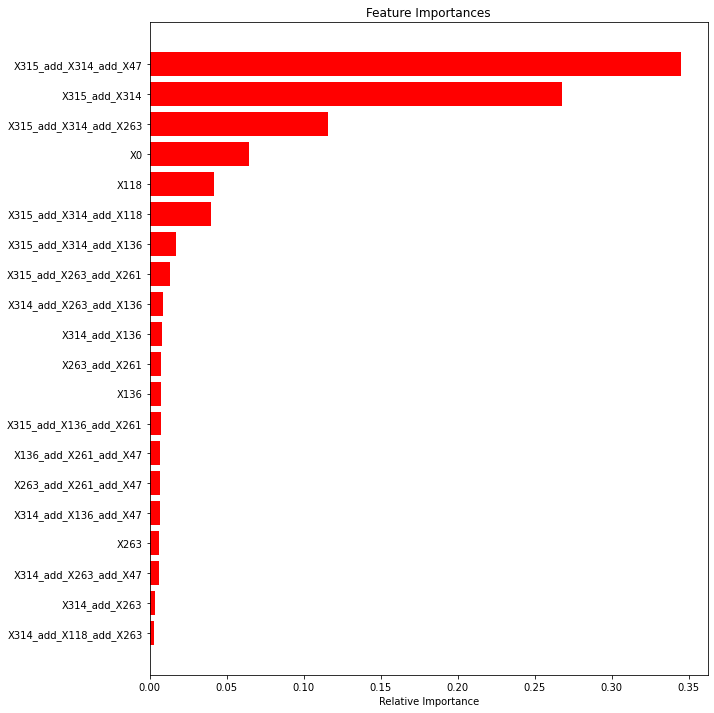

In [47]:
model = ExtraTreesRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_corr_et_model = ensemble(model,params,mean_interaction_train)

# Best model from the hyperparameter tuning
mean_corr_et_final = mean_corr_et_model.best_estimator_
mean_corr_et_final.fit(mean_interaction_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(mean_corr_et_final,mean_interaction_train)

# Final submission.csv for kaggle scores
mean_corr_submission = submission(mean_corr_et_final,mean_interaction_test)
save_model('mean_corr_et_final',mean_corr_et_final)

##### From above feature importances plot we can see that top features are interaction features.

In [48]:
mean_corr_submission.to_csv('mean_submission/mean_corr_et_submission.csv',index = False)

#### GLMM Encoding

In [49]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


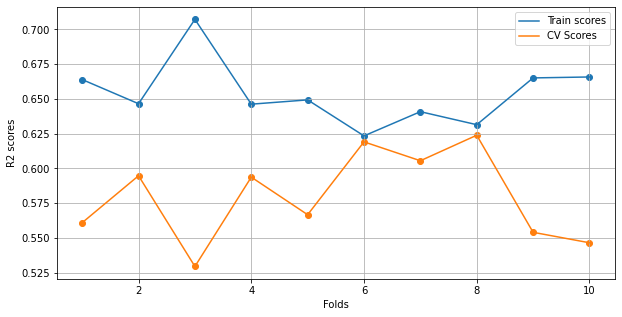

Best R2 score is  0.6238323774548814 and best hyperparameters is  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 8, 'min_impurity_decrease': 0, 'max_features': 0.95, 'max_depth': 3}

Plot representing the feature importances for the best model selected from hyperparameter tuning


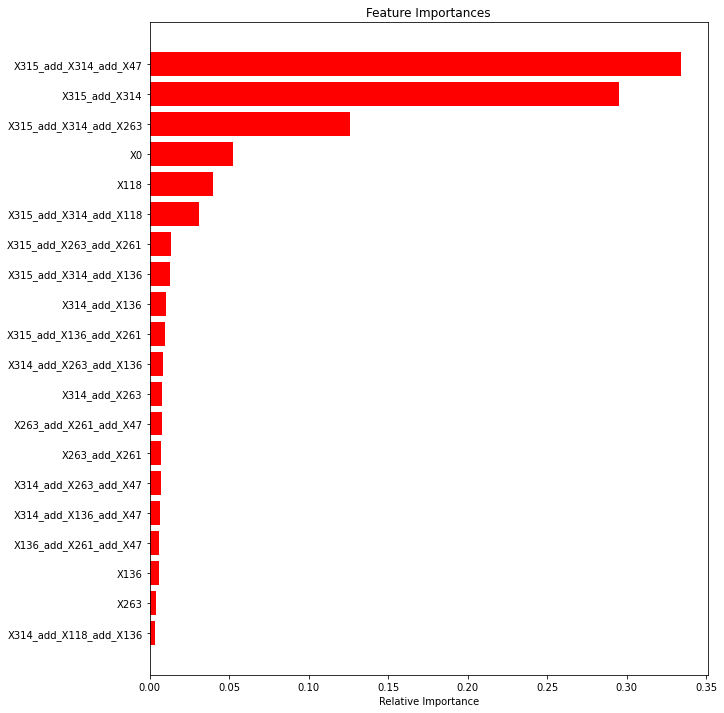

In [50]:
model = ExtraTreesRegressor(random_state = 42,max_features = 0.95,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_corr_et_model = ensemble(model,params,glmm_interaction_train)

# Best model from the hyperparameter tuning
glmm_corr_et_final = glmm_corr_et_model.best_estimator_
glmm_corr_et_final.fit(glmm_interaction_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(glmm_corr_et_final,glmm_interaction_train)

# Final submission.csv for kaggle scores
glmm_corr_submission = submission(glmm_corr_et_final,glmm_interaction_test)
save_model('glmm_corr_et_final',glmm_corr_et_final)

##### From above feature importances plot we can see that in top features are interaction features

In [51]:
glmm_corr_submission.to_csv('glmm_submission/glmm_corr_et_submission.csv',index = False)

### XG Boost

#### Label Encoding

In [52]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


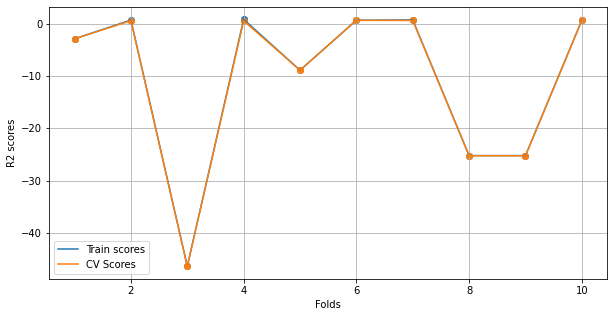

Best R2 score is  0.6216371862224491 and best hyperparameters is  {'subsample': 0.5, 'reg_alpha': 100, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.1}


In [53]:
model = XGBRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_corr_xgb_model = ensemble(model,params,label_interaction_train)

# Best model from the hyperparameter tuning
label_corr_xgb_final = label_corr_xgb_model.best_estimator_
label_corr_xgb_final.fit(label_interaction_train,y_train['y'].values)

# Final submission.csv for kaggle scores
label_corr_submission = submission(label_corr_xgb_final,label_interaction_test)
save_model('label_corr_xgb_final',label_corr_xgb_final)

In [54]:
label_corr_submission.to_csv('label_submission/label_corr_xgb_submission.csv',index = False)

#### Mean Encoding

In [55]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


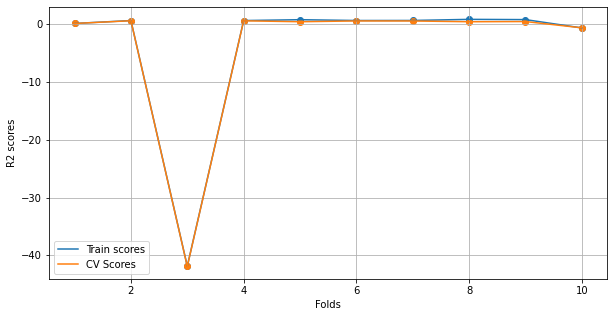

Best R2 score is  0.6142912928817483 and best hyperparameters is  {'subsample': 0.1, 'reg_alpha': 100, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1}


In [56]:
model = XGBRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_corr_xgb_model = ensemble(model,params,mean_interaction_train)

# Best model from the hyperparameter tuning
mean_corr_xgb_final = mean_corr_xgb_model.best_estimator_
mean_corr_xgb_final.fit(mean_interaction_train,y_train['y'].values)

# Final submission.csv for kaggle scores
mean_corr_submission = submission(mean_corr_xgb_final,mean_interaction_test)
save_model('mean_corr_xgb_final',mean_corr_xgb_final)

In [57]:
mean_corr_submission.to_csv('mean_submission/mean_corr_xgb_submission.csv',index = False)

#### GLMM encoding

In [58]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


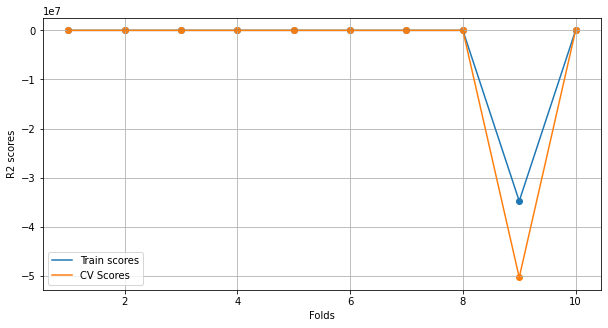

Best R2 score is  0.6203341794383641 and best hyperparameters is  {'subsample': 0.1, 'reg_alpha': 100, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.001, 'colsample_bytree': 0.1}


In [59]:
model = XGBRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_corr_xgb_model = ensemble(model,params,glmm_interaction_train)

# Best model from the hyperparameter tuning
glmm_corr_xgb_final = glmm_corr_xgb_model.best_estimator_
glmm_corr_xgb_final.fit(glmm_interaction_train,y_train['y'].values)

# Final submission.csv for kaggle scores
glmm_corr_submission = submission(glmm_corr_xgb_final,glmm_interaction_test)
save_model('glmm_corr_xgb_final',glmm_corr_xgb_final)

In [60]:
glmm_corr_submission.to_csv('glmm_submission/glmm_corr_xgb_submission.csv',index = False)

### Stacked Models

#### I will be using stacked models of (Random Forest, XG bosst, Extra tree regresssor) on Label, Mean and GLMM encoding. Using Ridge as final meta regressor with regularization set to 0 so it doesn't impact stacked models. 

#### Label Encoding

In [61]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_label_corr = StackingRegressor(estimators = [('rf',label_corr_rf_final),('xgb',label_corr_xgb_final),('et',label_corr_et_final)],final_estimator = ridge,cv = 10,n_jobs = -1)
stack_label_corr.fit(label_interaction_train,y_train['y'].values)
                
# Final submission.csv for kaggle scores
label_submission = submission(stack_label_corr,label_interaction_test)
save_model('stack_label_corr',stack_label_corr)

In [62]:
label_submission.to_csv('label_submission/label_corr_stack_submission.csv',index = False)

#### Mean Encoding

In [63]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_mean_corr= StackingRegressor(estimators = [('rf',mean_corr_rf_final),('xgb',mean_corr_xgb_final),('et',mean_corr_et_final)],final_estimator = ridge,cv = 10,n_jobs = -1)
stack_mean_corr.fit(mean_interaction_train,y_train['y'].values)
    
# Final submission.csv for kaggle scores
mean_submission = submission(stack_mean_corr,mean_interaction_test)
save_model('stack_mean_corr',stack_mean_corr)

In [64]:
mean_submission.to_csv('mean_submission/mean_corr_stack_submission.csv',index = False)

#### Glmm Encoding

In [65]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_glmm_corr = StackingRegressor(estimators = [('rf',glmm_corr_rf_final),('xgb',glmm_corr_xgb_final),('et',glmm_corr_et_final)],final_estimator = ridge,cv = 10,n_jobs = -1)
stack_glmm_corr.fit(glmm_interaction_train,y_train['y'].values)
    
# Final submission.csv for kaggle scores
glmm_submission = submission(stack_glmm_corr,glmm_interaction_test)
save_model('stack_glmm_corr',stack_glmm_corr)

In [66]:
glmm_submission.to_csv('glmm_submission/glmm_corr_stack_submission.csv',index = False)

## Datasets 2 (encoding of categorical variables + interaction features + PCA features)

### Linear Regression Models

#### Label Encoding

In [67]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98450.63110215253, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95688.38204222021, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92701.08609093228, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want 

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48249.8035433608, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6660.26514551483, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6568.254217916779, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want t

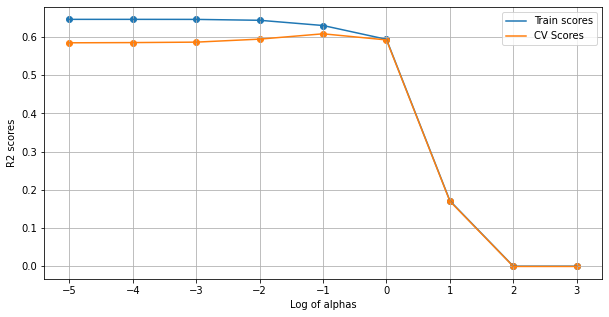

Best R2 score is  0.6084081844583822 and best hyperparameters is  {'alpha': 0.1}


In [68]:
#Hyperparameter tuning of Lasso model
label_corr_pca_lr_model = Lr_model(Lasso(),param,label_interaction_pca_train)

# Best model from the hyperparameter tuning
label_corr_pca_lr_final = label_corr_pca_lr_model.best_estimator_
label_corr_pca_lr_final.fit(label_interaction_pca_train,y_train)

# Final submission.csv for kaggle scores
label_corr_pca_submission = submission(label_corr_pca_lr_final,label_interaction_pca_test)
save_model('label_corr_pca_lr_final',label_corr_pca_lr_final)

In [69]:
label_corr_pca_submission.to_csv('label_submission/label_corr_pca_lasso_submission.csv',index = False)

#### Mean Encoding

In [70]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92968.65636896859, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90177.17400297998, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87478.20006877022, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want 

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51109.520869023254, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(


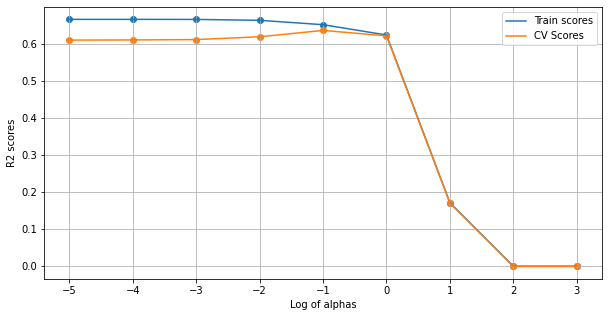

Best R2 score is  0.6358500769912151 and best hyperparameters is  {'alpha': 0.1}


In [71]:
#Hyperparameter tuning of Lasso model
mean_corr_pca_lr_model = Lr_model(Lasso(),param,mean_interaction_pca_train)

# Best model from the hyperparameter tuning
mean_corr_pca_lr_final = mean_corr_pca_lr_model.best_estimator_
mean_corr_pca_lr_final.fit(mean_interaction_pca_train,y_train)

# Final submission.csv for kaggle scores
mean_corr_pca_submission = submission(mean_corr_pca_lr_final,mean_interaction_pca_test)
save_model('mean_corr_pca_lr_final',mean_corr_pca_lr_final)

In [72]:
mean_corr_pca_submission.to_csv('mean_submission/mean_corr_pca_lasso_submission.csv',index = False)

#### GLMM encoding

In [73]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92901.15273084145, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90187.55933543062, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87632.43988684252, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want 

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52016.77870414402, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.85559628045303, tolerance: 54.29802543414943
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.92030819525826, tolerance: 54.564730724566886
  model = cd_fast.enet_coordinate_descent(


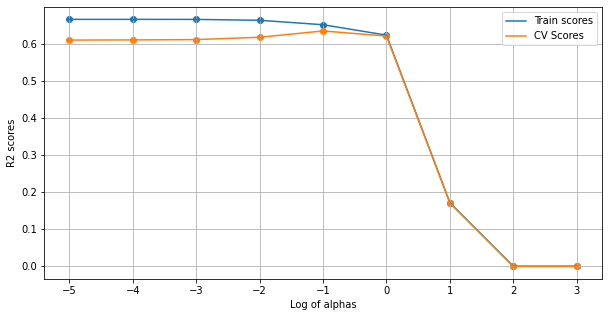

Best R2 score is  0.6342518657185774 and best hyperparameters is  {'alpha': 0.1}


In [74]:
#Hyperparameter tuning of Lasso model
glmm_corr_pca_lr_model = Lr_model(Lasso(),param,glmm_interaction_tsvd_train)

# Best model from the hyperparameter tuning
glmm_corr_pca_lr_final = glmm_corr_pca_lr_model.best_estimator_
glmm_corr_pca_lr_final.fit(glmm_interaction_pca_train,y_train)

# Final submission.csv for kaggle scores
glmm_corr_pca_submission = submission(glmm_corr_pca_lr_final,glmm_interaction_pca_test)
save_model('glmm_corr_pca_lr_final',glmm_corr_pca_lr_final)

In [75]:
glmm_corr_pca_submission.to_csv('glmm_submission/glmm_corr_pca_lasso_submission.csv',index = False)

### Random Forest Models

#### Label Encoding

In [76]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


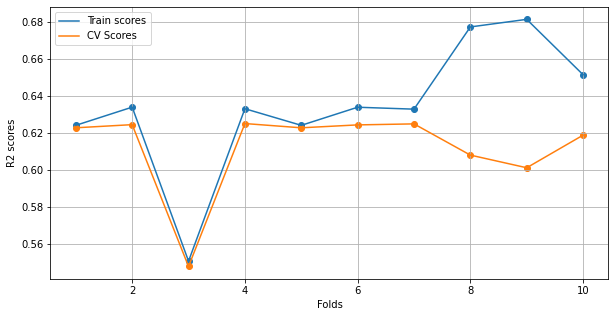

Best R2 score is  0.6250911063756155 and best hyperparameters is  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0001, 'max_features': 0.95, 'max_depth': 3}

Plot representing the feature importances for the best model selected from hyperparameter tuning


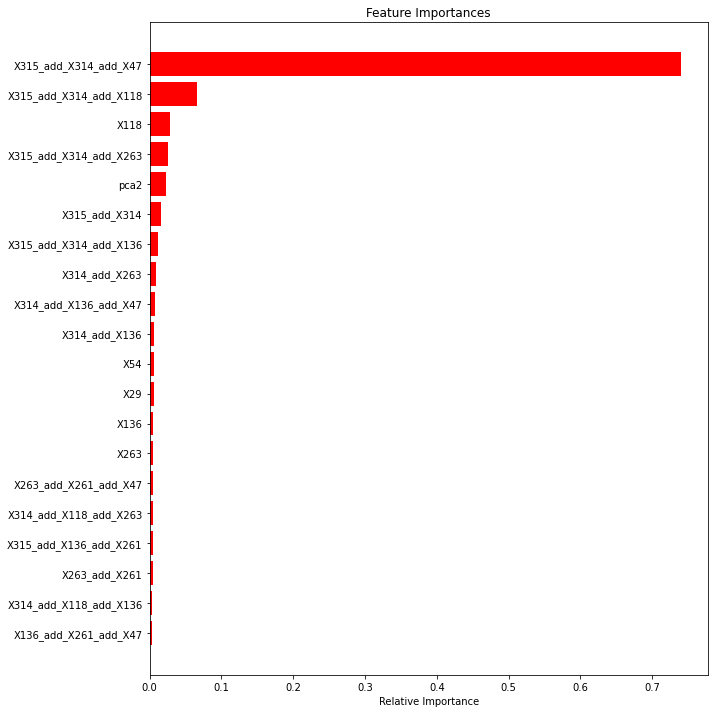

In [77]:
model = RandomForestRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_corr_pca_rf_model = ensemble(model,params,label_interaction_pca_train)

# Best model from the hyperparameter tuning
label_corr_pca_rf_final = label_corr_pca_rf_model.best_estimator_
label_corr_pca_rf_final.fit(label_interaction_pca_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(label_corr_pca_rf_final,label_interaction_pca_train)

# Final submission.csv for kaggle scores
label_corr_pca_submission = submission(label_corr_pca_rf_final,label_interaction_pca_test)
save_model('label_corr_pca_rf_final',label_corr_pca_rf_final)

##### From above feature importances plot we can see that top features are interaction features and a single pca feature is present.

In [78]:
label_corr_pca_submission.to_csv('label_submission/label_corr_pca_rf_submission.csv',index = False)

#### Mean Encoding

In [79]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


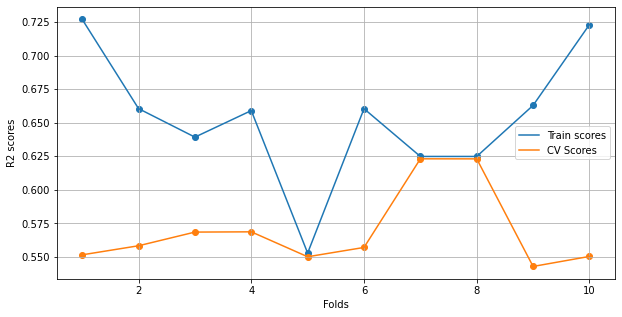

Best R2 score is  0.6230785360976208 and best hyperparameters is  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.01, 'max_features': 0.95, 'max_depth': 2}

Plot representing the feature importances for the best model selected from hyperparameter tuning


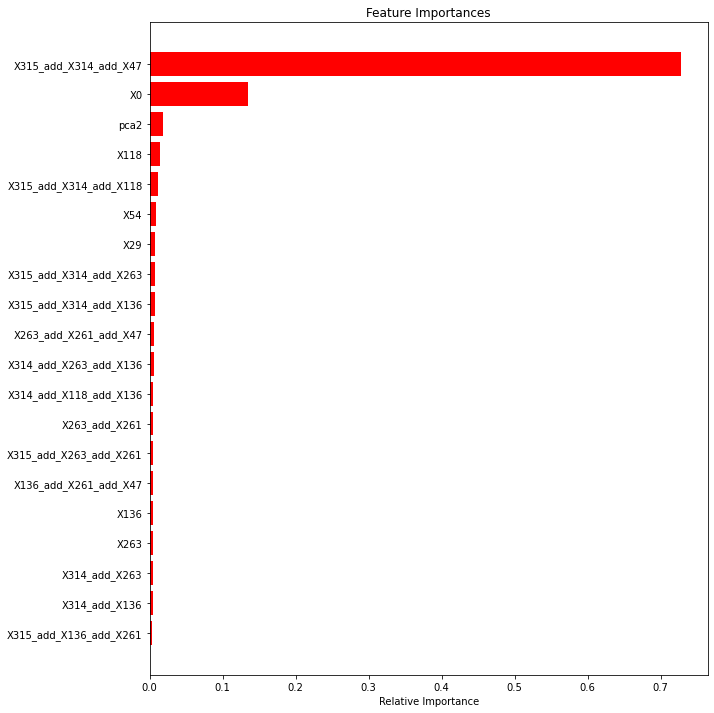

In [80]:
model = RandomForestRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_corr_pca_rf_model = ensemble(model,params,mean_interaction_pca_train)

# Best model from the hyperparameter tuning
mean_corr_pca_rf_final = mean_corr_pca_rf_model.best_estimator_
mean_corr_pca_rf_final.fit(mean_interaction_pca_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(mean_corr_pca_rf_final,mean_interaction_pca_train)

# Final submission.csv for kaggle scores
mean_corr_pca_submission = submission(mean_corr_pca_rf_final,mean_interaction_pca_test)
save_model('mean_corr_pca_rf_final',mean_corr_pca_rf_final)

##### From above feature importances plot we can see that interaction features has highest importance. We can see that pca feature has higher importance when using Mean encoding than label encoding.

In [81]:
mean_corr_pca_submission.to_csv('mean_submission/mean_corr_pca_rf_submission.csv',index = False)

#### GLMM Encoding

In [82]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


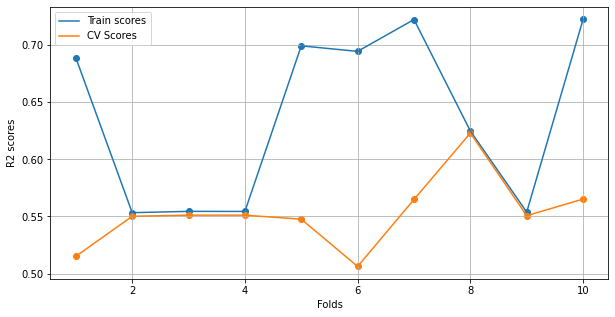

Best R2 score is  0.6230206907852199 and best hyperparameters is  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.1, 'max_features': 0.95, 'max_depth': 2}

Plot representing the feature importances for the best model selected from hyperparameter tuning


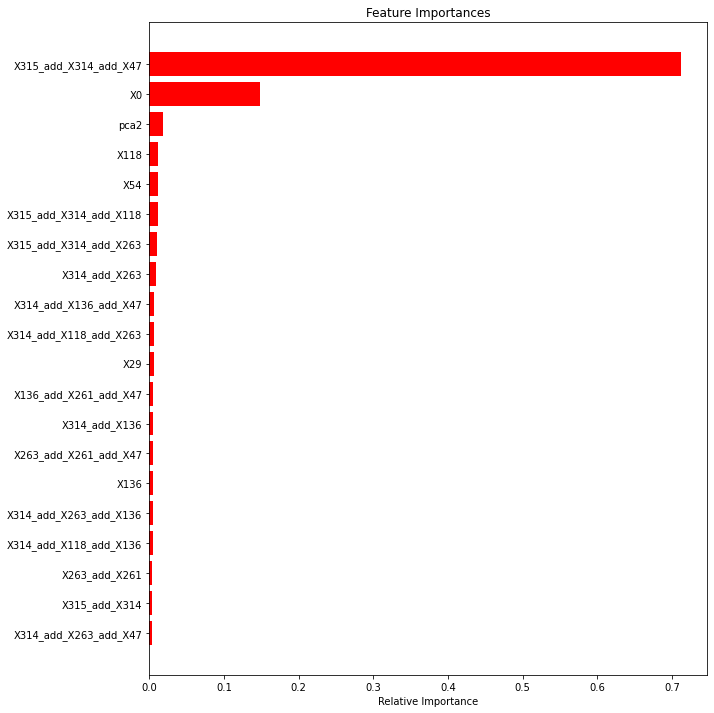

In [83]:
model = RandomForestRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_corr_pca_rf_model = ensemble(model,params,glmm_interaction_pca_train)

# Best model from the hyperparameter tuning
glmm_corr_pca_rf_final = glmm_corr_pca_rf_model.best_estimator_
glmm_corr_pca_rf_final.fit(glmm_interaction_pca_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(glmm_corr_pca_rf_final,glmm_interaction_pca_train)

# Final submission.csv for kaggle scores
glmm_corr_pca_submission = submission(glmm_corr_pca_rf_final,glmm_interaction_pca_test)
save_model('glmm_corr_pca_rf_final',glmm_corr_pca_rf_final)

##### From above feature importances plot we can see that interaction features has highest importance. We can see that pca feature has higher importance when using Glmm encoding than label encoding.

In [84]:
glmm_corr_pca_submission.to_csv('glmm_submission/glmm_corr_pca_rf_submission.csv',index = False)

### Extratrees Regressor

#### Label Encoding

In [85]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


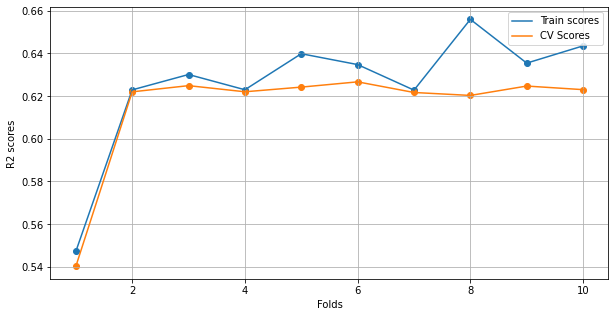

Best R2 score is  0.6266665952860926 and best hyperparameters is  {'n_estimators': 500, 'min_samples_split': 7, 'min_samples_leaf': 6, 'min_impurity_decrease': 0, 'max_features': 0.95, 'max_depth': 4}

Plot representing the feature importances for the best model selected from hyperparameter tuning


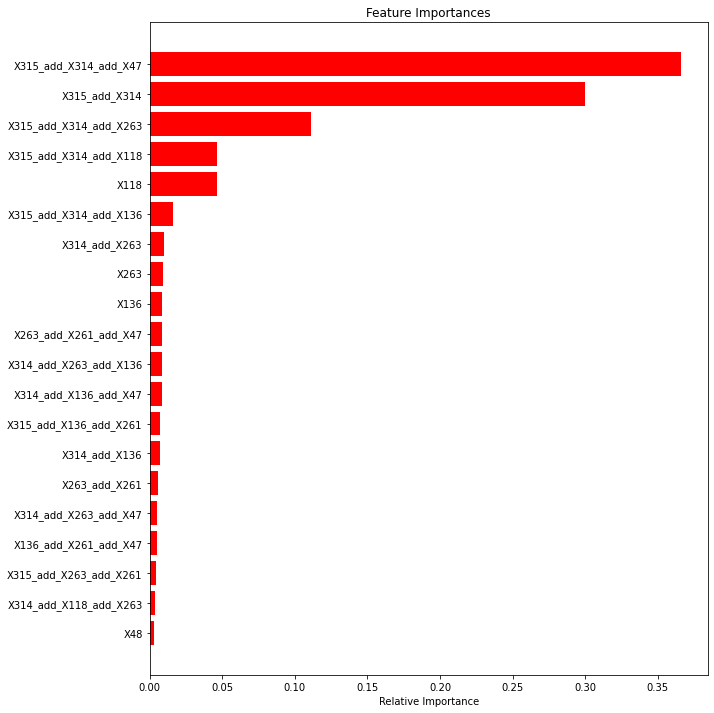

In [86]:
model = ExtraTreesRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_corr_pca_et_model = ensemble(model,params,label_interaction_tsvd_train)

# Best model from the hyperparameter tuning
label_corr_pca_et_final = label_corr_pca_et_model.best_estimator_
label_corr_pca_et_final.fit(label_interaction_pca_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(label_corr_pca_et_final,label_interaction_pca_train)

# Final submission.csv for kaggle scores
label_corr_pca_submission = submission(label_corr_pca_et_final,label_interaction_pca_test)
save_model('label_corr_pca_et_final',label_corr_pca_et_final)

##### From above feature importances plot we can see that top features are interaction without any pca features in top 20

In [87]:
label_corr_pca_submission.to_csv('label_submission/label_corr_pca_et_submission.csv',index = False)

#### Mean Encoding

In [88]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


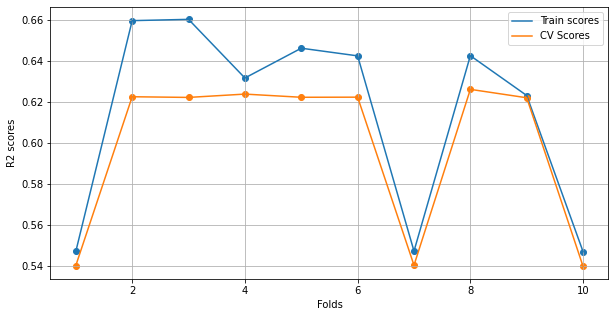

Best R2 score is  0.6260709107700612 and best hyperparameters is  {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.01, 'max_features': 0.95, 'max_depth': 5}

Plot representing the feature importances for the best model selected from hyperparameter tuning


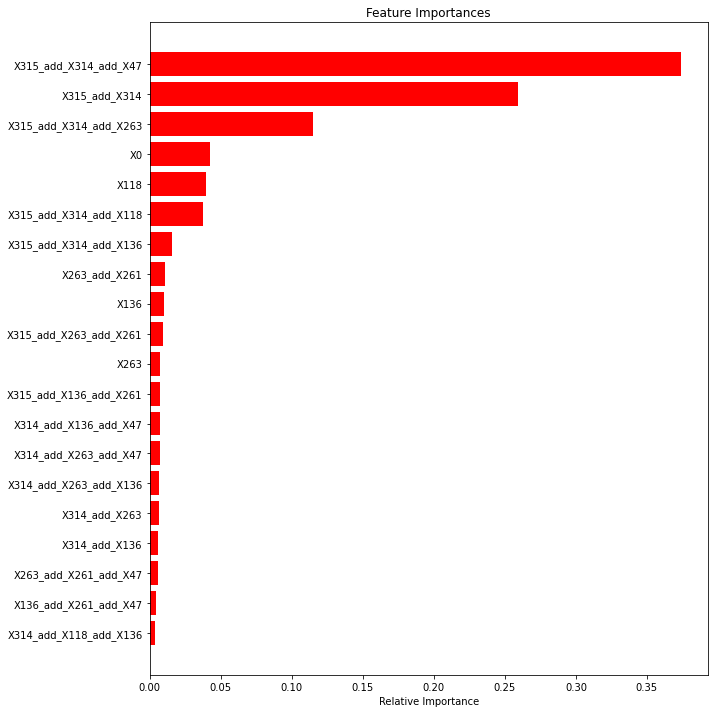

In [89]:
model = ExtraTreesRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_corr_pca_et_model = ensemble(model,params,mean_interaction_pca_train)

# Best model from the hyperparameter tuning
mean_corr_pca_et_final = mean_corr_pca_et_model.best_estimator_
mean_corr_pca_et_final.fit(mean_interaction_pca_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(mean_corr_pca_et_final,mean_interaction_pca_train)

# Final submission.csv for kaggle scores
mean_corr_pca_submission = submission(mean_corr_pca_et_final,mean_interaction_pca_test)
save_model('mean_corr_pca_et_final',mean_corr_pca_et_final)

##### From above feature importances plot we can see that top features are interaction and categorical without any pca features in top 20

In [90]:
mean_corr_pca_submission.to_csv('mean_submission/mean_corr_pca_et_submission.csv',index = False)

#### GLMM Encoding

In [91]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


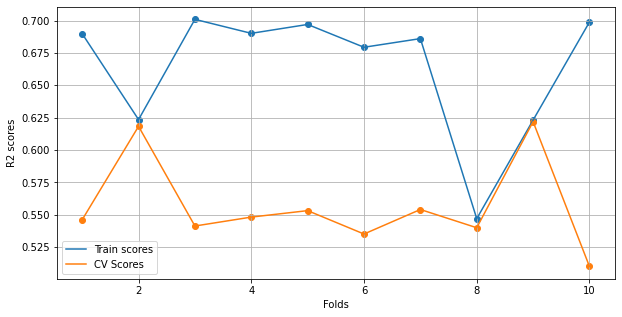

Best R2 score is  0.6219026175780957 and best hyperparameters is  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 7, 'min_impurity_decrease': 1e-05, 'max_features': 0.95, 'max_depth': 2}

Plot representing the feature importances for the best model selected from hyperparameter tuning


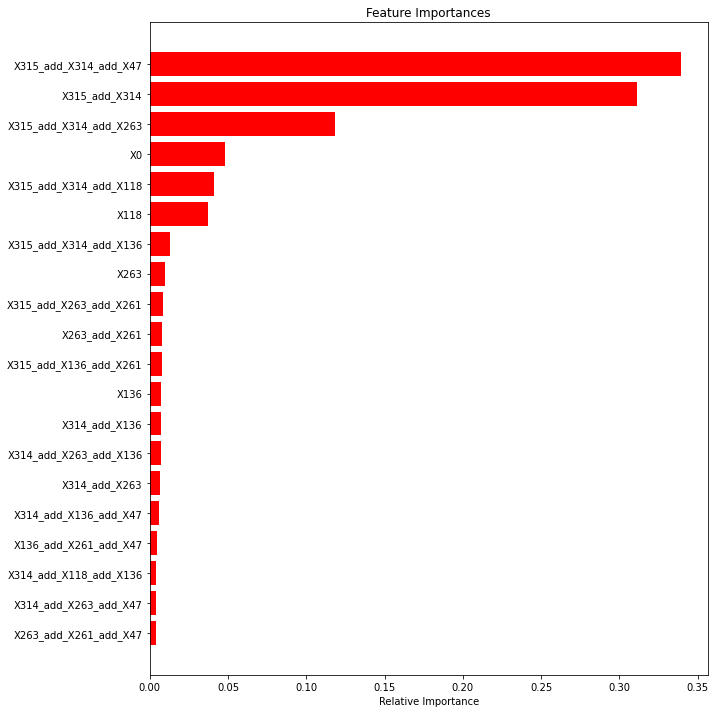

In [92]:
model = ExtraTreesRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_corr_pca_et_model = ensemble(model,params,glmm_interaction_pca_train)

# Best model from the hyperparameter tuning
glmm_corr_pca_et_final = glmm_corr_pca_et_model.best_estimator_
glmm_corr_pca_et_final.fit(glmm_interaction_pca_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(glmm_corr_pca_et_final,glmm_interaction_pca_train)

# Final submission.csv for kaggle scores
glmm_corr_pca_submission = submission(glmm_corr_pca_et_final,glmm_interaction_pca_test)
save_model('glmm_corr_pca_et_final',glmm_corr_pca_et_final)

##### From above feature importances plot we can see that top features are interaction without any pca features in top 20

In [93]:
glmm_corr_pca_submission.to_csv('glmm_submission/glmm_corr_pca_et_submission.csv',index = False)

### XG Boost

#### Label Encoding

In [151]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


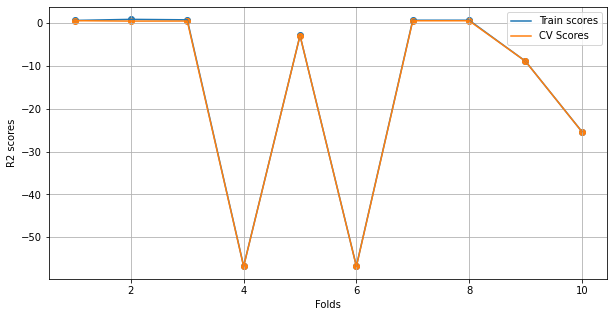

Best R2 score is  0.6103657471419712 and best hyperparameters is  {'subsample': 0.3, 'reg_alpha': 10, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}


In [152]:
model = XGBRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_corr_pca_xgb_model = ensemble(model,params,label_interaction_pca_train)

# Best model from the hyperparameter tuning
label_corr_pca_xgb_final = label_corr_pca_xgb_model.best_estimator_
label_corr_pca_xgb_final.fit(label_interaction_pca_train,y_train['y'].values)

# Final submission.csv for kaggle scores
label_corr_pca_submission = submission(label_corr_pca_xgb_final,label_interaction_pca_test)
save_model('label_corr_pca_xgb_final',label_corr_pca_xgb_final)

In [153]:
label_corr_pca_submission.to_csv('label_submission/label_corr_pca_xgb_submission.csv',index = False)

#### Mean Encoding

In [97]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


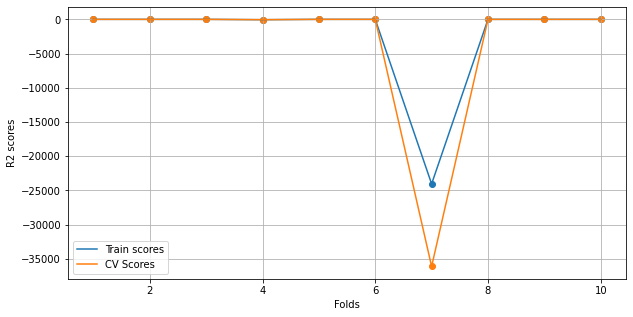

Best R2 score is  0.6122369193900032 and best hyperparameters is  {'subsample': 0.1, 'reg_alpha': 1e-05, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.01, 'colsample_bytree': 0.1}


In [98]:
model = XGBRegressor(objective='reg:squarederror',n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_corr_pca_xgb_model = ensemble(model,params,mean_interaction_pca_train)

# Best model from the hyperparameter tuning
mean_corr_pca_xgb_final = mean_corr_pca_xgb_model.best_estimator_
mean_corr_pca_xgb_final.fit(mean_interaction_pca_train,y_train['y'].values)

# Final submission.csv for kaggle scores
mean_corr_pca_submission = submission(mean_corr_pca_xgb_final,mean_interaction_pca_test)
save_model('mean_corr_pca_xgb_final',mean_corr_pca_xgb_final)

In [99]:
mean_corr_pca_submission.to_csv('mean_submission/mean_corr_pca_xgb_submission.csv',index = False)

#### GLMM encoding

In [100]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


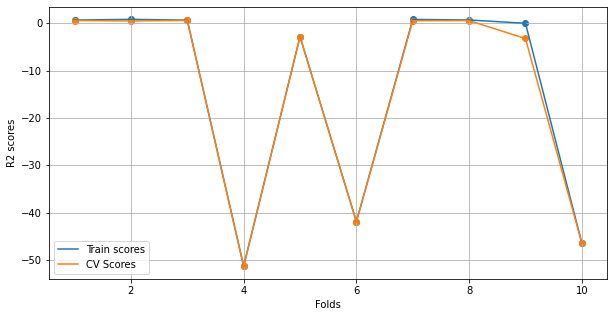

Best R2 score is  0.5883075632089526 and best hyperparameters is  {'subsample': 0.5, 'reg_alpha': 10, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}


In [101]:
model = XGBRegressor(objective='reg:squarederror',n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_corr_pca_xgb_model = ensemble(model,params,glmm_interaction_pca_train)

# Best model from the hyperparameter tuning
glmm_corr_pca_xgb_final = glmm_corr_pca_xgb_model.best_estimator_
glmm_corr_pca_xgb_final.fit(glmm_interaction_pca_train,y_train['y'].values)

# Final submission.csv for kaggle scores
glmm_corr_pca_submission = submission(glmm_corr_pca_xgb_final,glmm_interaction_pca_test)
save_model('glmm_corr_pca_xgb_final',glmm_corr_pca_xgb_final)

In [102]:
glmm_corr_pca_submission.to_csv('glmm_submission/glmm_corr_pca_xgb_submission.csv',index = False)

### Stacked Models

#### I will be using stacked models of (Random Forest, XG bosst, Extra tree regresssor) on Label, Mean and GLMM encoding. Using Ridge as final meta regressor with regularization set to 0 so it doesn't impact stacked models. 

#### Label Encoding

In [154]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_label_corr_pca = StackingRegressor(estimators = [('rf',label_corr_pca_rf_final),('xgb',label_corr_pca_xgb_final),('et',label_corr_pca_et_final)],final_estimator = ridge,cv = 10,n_jobs = -1)
stack_label_corr_pca.fit(label_interaction_pca_train,y_train['y'].values)
# Final submission.csv for kaggle scores
label_submission = submission(stack_label_corr_pca,label_interaction_pca_test)
save_model('stack_label_corr_pca',stack_label_corr_pca)

In [155]:
label_submission.to_csv('label_submission/label_corr_pca_stack_submission.csv',index = False)

#### Mean Encoding

In [105]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_mean_corr_pca = StackingRegressor(estimators = [('rf',mean_corr_pca_rf_final),('xgb',mean_corr_pca_xgb_final),('et',mean_corr_pca_et_final)],final_estimator = ridge,cv = 10,n_jobs = -1)
stack_mean_corr_pca.fit(mean_interaction_pca_train,y_train['y'].values)
    
# Final submission.csv for kaggle scores
mean_submission = submission(stack_mean_corr_pca,mean_interaction_pca_test)
save_model('stack_mean_corr_pca',stack_mean_corr_pca)

In [106]:
mean_submission.to_csv('mean_submission/mean_corr_pca_stack_submission.csv',index = False)

#### Glmm Encoding

In [107]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_glmm_corr_pca = StackingRegressor(estimators = [('rf',glmm_corr_pca_rf_final),('xgb',glmm_corr_pca_xgb_final),('et',glmm_corr_pca_et_final)],final_estimator = ridge,cv = 10,n_jobs = -1)
stack_glmm_corr_pca.fit(glmm_interaction_pca_train,y_train['y'].values)
    
# Final submission.csv for kaggle scores
glmm_submission = submission(stack_glmm_corr_pca,glmm_interaction_pca_test)
save_model('stack_glmm_corr_pca',stack_glmm_corr_pca)

In [108]:
glmm_submission.to_csv('glmm_submission/glmm_corr_pca_stack_submission.csv',index = False)

## Datasets 3 (encoding of categorical variables + interaction features + TSVD features)

### Linear Regression Models

#### Label Encoding

In [109]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98406.21957923379, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95643.11478408713, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92580.9170879297, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want t

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49598.128225797605, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6505.307651697891, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6848.378682332113, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might wan

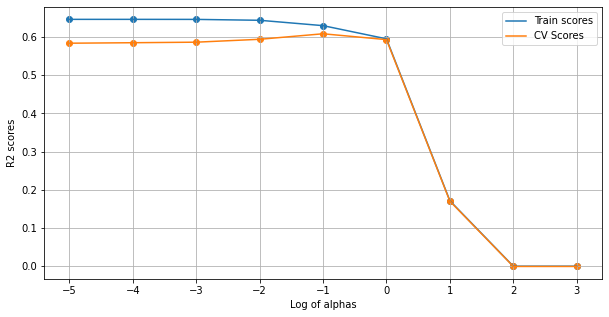

Best R2 score is  0.6084670745269225 and best hyperparameters is  {'alpha': 0.1}


In [110]:
#Hyperparameter tuning of Lasso model
label_corr_tsvd_lr_model = Lr_model(Lasso(),param,label_interaction_tsvd_train)

# Best model from the hyperparameter tuning
label_corr_tsvd_lr_final = label_corr_tsvd_lr_model.best_estimator_
label_corr_tsvd_lr_final.fit(label_interaction_tsvd_train,y_train)

# Final submission.csv for kaggle scores
label_corr_tsvd_submission = submission(label_corr_tsvd_lr_final,label_interaction_tsvd_test)
save_model('label_corr_tsvd_lr_final',label_corr_tsvd_lr_final)

In [111]:
label_corr_tsvd_submission.to_csv('label_submission/label_corr_tsvd_lasso_submission.csv',index = False)

#### Mean Encoding

In [112]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92920.99842650766, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90132.41984413653, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87344.23834286086, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want 

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51238.37459928558, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(


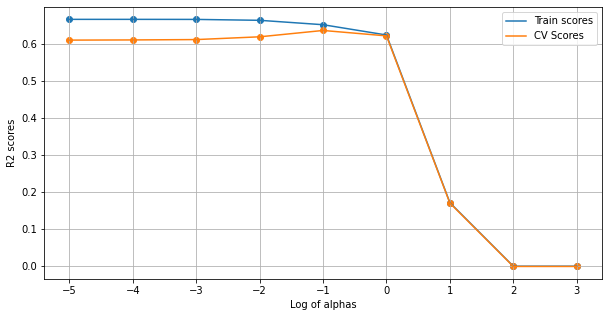

Best R2 score is  0.6356486502503376 and best hyperparameters is  {'alpha': 0.1}


In [113]:
#Hyperparameter tuning of Lasso model
mean_corr_tsvd_lr_model = Lr_model(Lasso(),param,mean_interaction_tsvd_train)

# Best model from the hyperparameter tuning
mean_corr_tsvd_lr_final = mean_corr_tsvd_lr_model.best_estimator_
mean_corr_tsvd_lr_final.fit(mean_interaction_tsvd_train,y_train)

# Final submission.csv for kaggle scores
mean_corr_tsvd_submission = submission(mean_corr_tsvd_lr_final,mean_interaction_tsvd_test)
save_model('mean_corr_tsvd_lr_final',mean_corr_tsvd_lr_final)

In [114]:
mean_corr_tsvd_submission.to_csv('mean_submission/mean_corr_tsvd_lasso_submission.csv',index = False)

#### GLMM encoding

In [115]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92901.15273084145, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90187.55933543062, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87632.43988684252, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want 

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52016.77870414402, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.85559628045303, tolerance: 54.29802543414943
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.92030819525826, tolerance: 54.564730724566886
  model = cd_fast.enet_coordinate_descent(


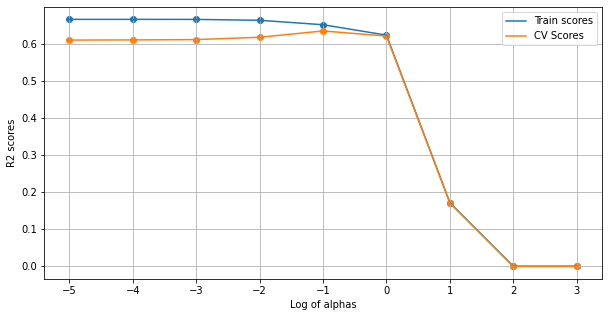

Best R2 score is  0.6342518657185774 and best hyperparameters is  {'alpha': 0.1}


In [116]:
#Hyperparameter tuning of Lasso model
glmm_corr_tsvd_lr_model = Lr_model(Lasso(),param,glmm_interaction_tsvd_train)

# Best model from the hyperparameter tuning
glmm_corr_tsvd_lr_final = glmm_corr_tsvd_lr_model.best_estimator_
glmm_corr_tsvd_lr_final.fit(glmm_interaction_tsvd_train,y_train)

# Final submission.csv for kaggle scores
glmm_corr_tsvd_submission = submission(glmm_corr_tsvd_lr_final,glmm_interaction_tsvd_test)
save_model('glmm_corr_tsvd_lr_final',glmm_corr_tsvd_lr_final)

In [117]:
glmm_corr_tsvd_submission.to_csv('glmm_submission/glmm_corr_tsvd_lasso_submission.csv',index = False)

### Random Forest Models

#### Label Encoding

In [118]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


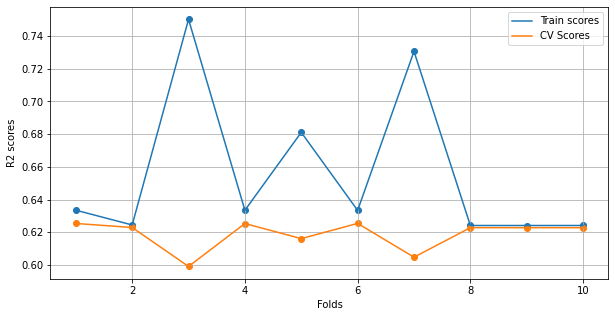

Best R2 score is  0.6253889504757411 and best hyperparameters is  {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 9, 'min_impurity_decrease': 1e-05, 'max_features': 0.95, 'max_depth': 3}

Plot representing the feature importances for the best model selected from hyperparameter tuning


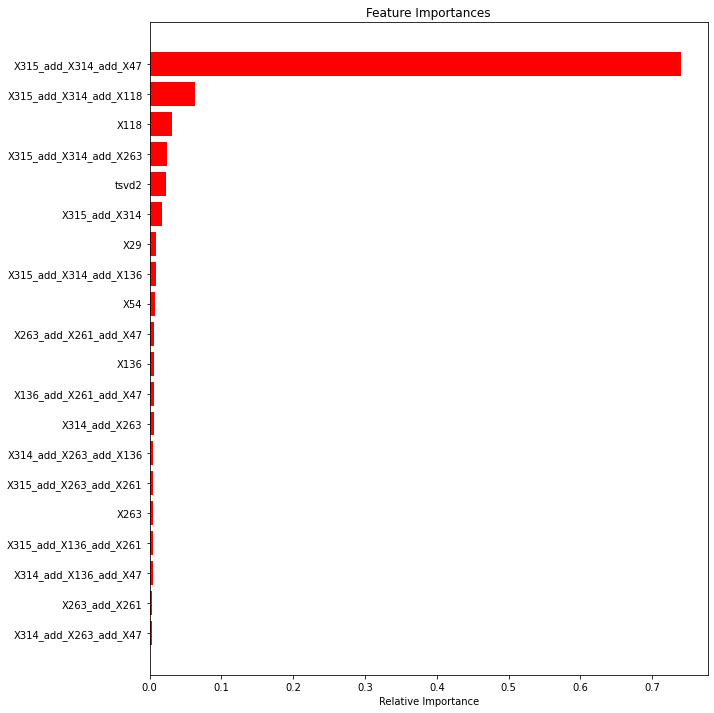

In [119]:
model = RandomForestRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_corr_tsvd_rf_model = ensemble(model,params,label_interaction_tsvd_train)

# Best model from the hyperparameter tuning
label_corr_tsvd_rf_final = label_corr_tsvd_rf_model.best_estimator_
label_corr_tsvd_rf_final.fit(label_interaction_tsvd_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(label_corr_tsvd_rf_final,label_interaction_tsvd_train)

# Final submission.csv for kaggle scores
label_corr_tsvd_submission = submission(label_corr_tsvd_rf_final,label_interaction_tsvd_test)
save_model('label_corr_tsvd_rf_final',label_corr_tsvd_rf_final)

##### From above feature importances plot we can see that a single tsvd feature has highest importance and rest are interaction features

In [120]:
label_corr_tsvd_submission.to_csv('label_submission/label_corr_tsvd_rf_submission.csv',index = False)

#### Mean Encoding

In [121]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


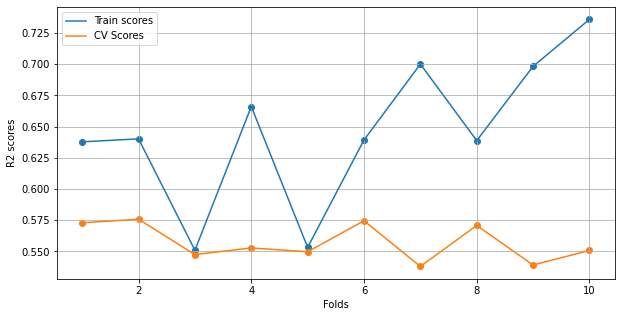

Best R2 score is  0.575774446708583 and best hyperparameters is  {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0001, 'max_features': 0.95, 'max_depth': 3}

Plot representing the feature importances for the best model selected from hyperparameter tuning


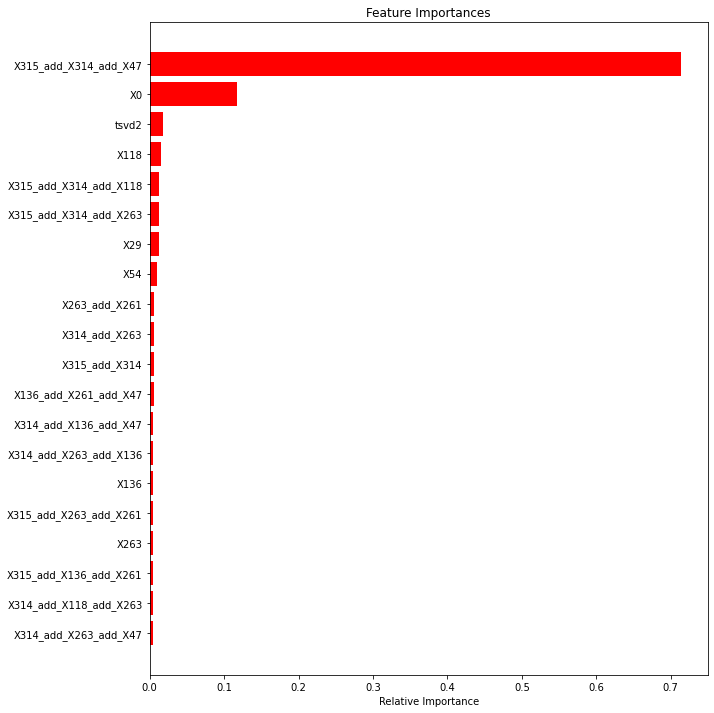

In [122]:
model = RandomForestRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_corr_tsvd_rf_model = ensemble(model,params,mean_interaction_tsvd_train)

# Best model from the hyperparameter tuning
mean_corr_tsvd_rf_final = mean_corr_tsvd_rf_model.best_estimator_
mean_corr_tsvd_rf_final.fit(mean_interaction_tsvd_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(mean_corr_tsvd_rf_final,mean_interaction_tsvd_train)

# Final submission.csv for kaggle scores
mean_corr_tsvd_submission = submission(mean_corr_tsvd_rf_final,mean_interaction_tsvd_test)
save_model('mean_corr_tsvd_rf_final',mean_corr_tsvd_rf_final)

##### From above feature importances plot we can see that interaction features has highest importance. We can see that tsvd feature has higher importance when using Mean encoding than label encoding.

In [123]:
mean_corr_tsvd_submission.to_csv('mean_submission/mean_corr_tsvd_rf_submission.csv',index = False)

#### GLMM Encoding

In [124]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


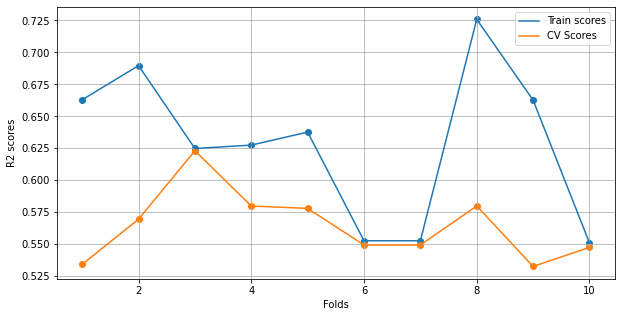

Best R2 score is  0.6230306765030914 and best hyperparameters is  {'n_estimators': 350, 'min_samples_split': 9, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_features': 0.95, 'max_depth': 2}

Plot representing the feature importances for the best model selected from hyperparameter tuning


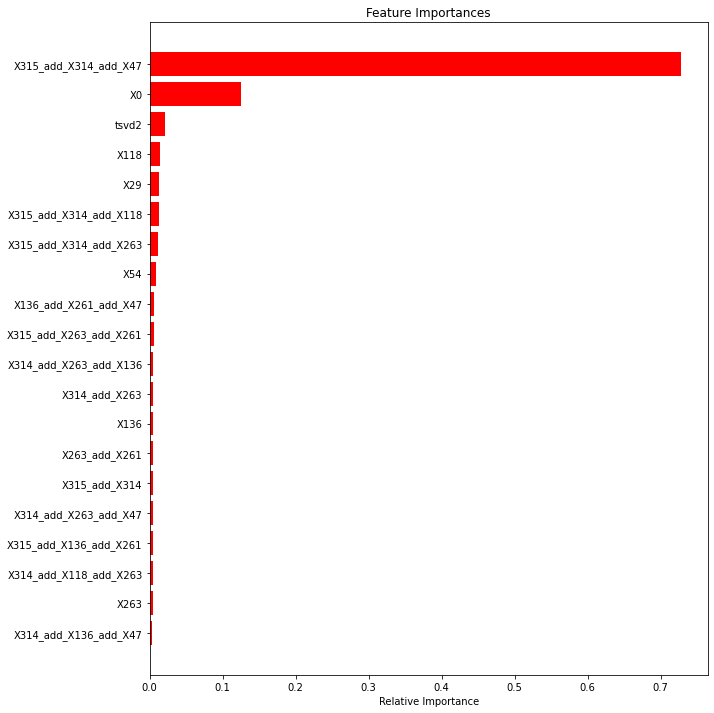

In [125]:
model = RandomForestRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_corr_tsvd_rf_model = ensemble(model,params,glmm_interaction_tsvd_train)

# Best model from the hyperparameter tuning
glmm_corr_tsvd_rf_final = glmm_corr_tsvd_rf_model.best_estimator_
glmm_corr_tsvd_rf_final.fit(glmm_interaction_tsvd_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(glmm_corr_tsvd_rf_final,glmm_interaction_tsvd_train)

# Final submission.csv for kaggle scores
glmm_corr_tsvd_submission = submission(glmm_corr_tsvd_rf_final,glmm_interaction_tsvd_test)
save_model('glmm_corr_tsvd_rf_final',glmm_corr_tsvd_rf_final)

##### From above feature importances plot we can see that interaction features has highest importance. We can see that tsvd feature has higher importance when using glmm encoding than label encoding.

In [126]:
glmm_corr_tsvd_submission.to_csv('glmm_submission/glmm_corr_tsvd_rf_submission.csv',index = False)

### Extratrees Regressor

#### Label Encoding

In [127]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


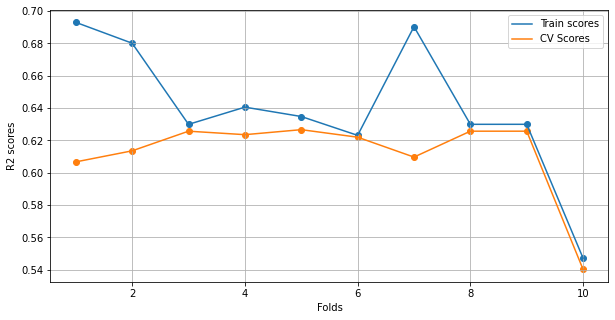

Best R2 score is  0.6265710012936407 and best hyperparameters is  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.01, 'max_features': 0.95, 'max_depth': 4}

Plot representing the feature importances for the best model selected from hyperparameter tuning


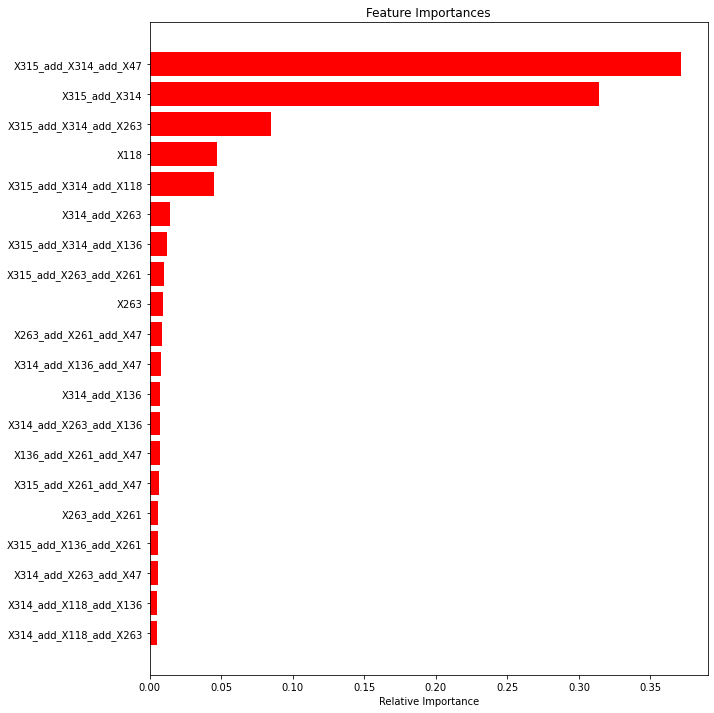

In [128]:
model = ExtraTreesRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_corr_tsvd_et_model = ensemble(model,params,label_interaction_tsvd_train)

# Best model from the hyperparameter tuning
label_corr_tsvd_et_final = label_corr_tsvd_et_model.best_estimator_
label_corr_tsvd_et_final.fit(label_interaction_tsvd_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(label_corr_tsvd_et_final,label_interaction_tsvd_train)

# Final submission.csv for kaggle scores
label_corr_tsvd_submission = submission(label_corr_tsvd_et_final,label_interaction_tsvd_test)
save_model('label_corr_tsvd_et_final',label_corr_tsvd_et_final)

##### From above feature importances plot we can see that top features are interaction without any tsvd features in top 20

In [129]:
label_corr_tsvd_submission.to_csv('label_submission/label_corr_tsvd_et_submission.csv',index = False)

#### Mean Encoding

In [130]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


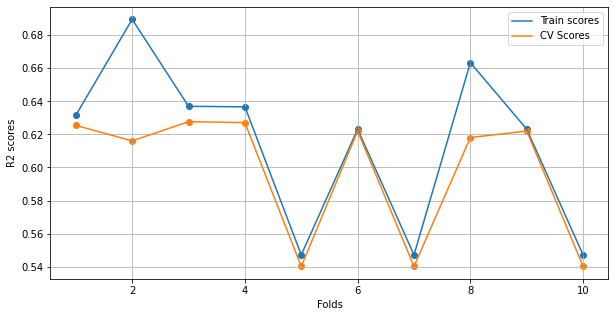

Best R2 score is  0.6276831187633062 and best hyperparameters is  {'n_estimators': 350, 'min_samples_split': 8, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.0001, 'max_features': 0.95, 'max_depth': 4}

Plot representing the feature importances for the best model selected from hyperparameter tuning


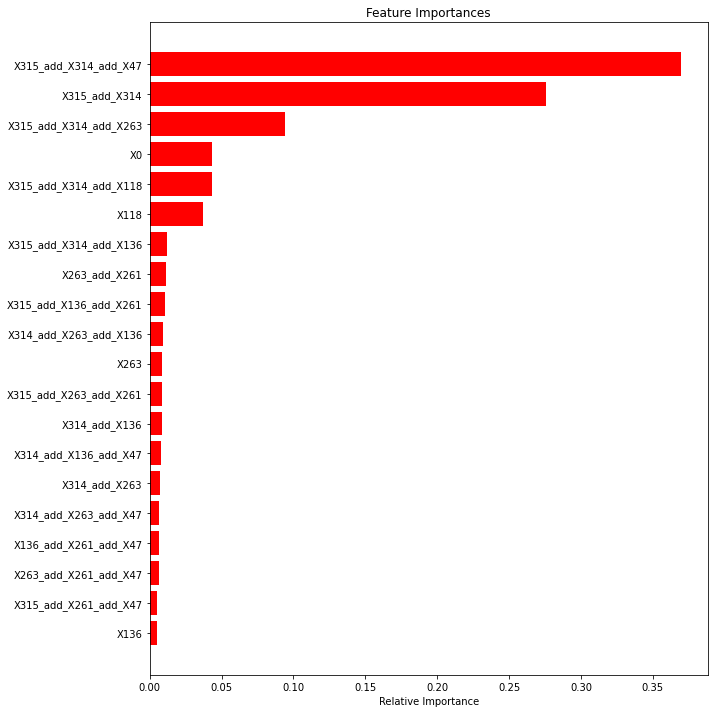

In [131]:
model = ExtraTreesRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_corr_tsvd_et_model = ensemble(model,params,mean_interaction_tsvd_train)

# Best model from the hyperparameter tuning
mean_corr_tsvd_et_final = mean_corr_tsvd_et_model.best_estimator_
mean_corr_tsvd_et_final.fit(mean_interaction_tsvd_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(mean_corr_tsvd_et_final,mean_interaction_tsvd_train)

# Final submission.csv for kaggle scores
mean_corr_tsvd_submission = submission(mean_corr_tsvd_et_final,mean_interaction_tsvd_test)
save_model('mean_corr_tsvd_et_final',mean_corr_tsvd_et_final)

##### From above feature importances plot we can see that top features are interaction and categorical without any tsvd features in top 20

In [132]:
mean_corr_tsvd_submission.to_csv('mean_submission/mean_corr_tsvd_et_submission.csv',index = False)

#### GLMM Encoding

In [133]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


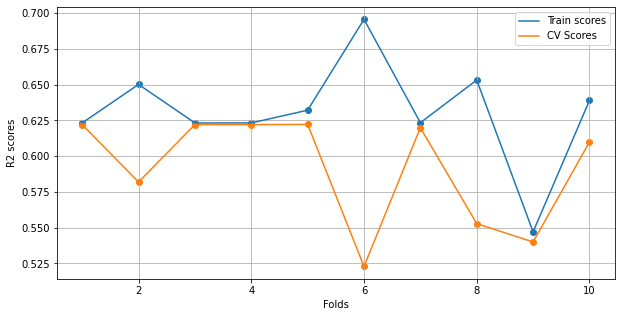

Best R2 score is  0.6221900758457728 and best hyperparameters is  {'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.0001, 'max_features': 0.95, 'max_depth': 3}

Plot representing the feature importances for the best model selected from hyperparameter tuning


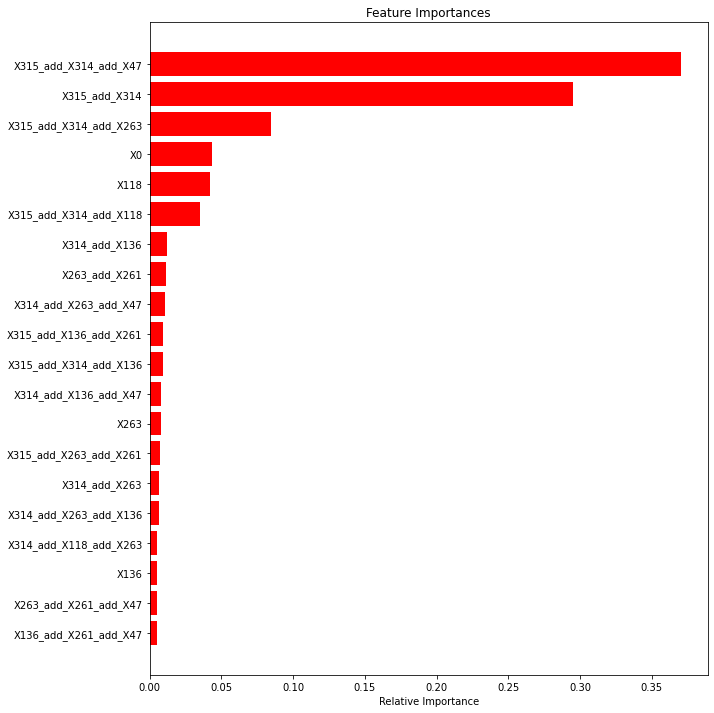

In [134]:
model = ExtraTreesRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_corr_tsvd_et_model = ensemble(model,params,glmm_interaction_tsvd_train)

# Best model from the hyperparameter tuning
glmm_corr_tsvd_et_final = glmm_corr_tsvd_et_model.best_estimator_
glmm_corr_tsvd_et_final.fit(glmm_interaction_tsvd_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(glmm_corr_tsvd_et_final,glmm_interaction_tsvd_train)

# Final submission.csv for kaggle scores
glmm_corr_tsvd_submission = submission(glmm_corr_tsvd_et_final,glmm_interaction_tsvd_test)
save_model('glmm_corr_tsvd_et_final',glmm_corr_tsvd_et_final)

##### From above feature importances plot we can see that top features are interaction and categorical without any tsvd features in top 20

In [135]:
glmm_corr_tsvd_submission.to_csv('glmm_submission/glmm_corr_tsvd_et_submission.csv',index = False)

### XG Boost

#### Label Encoding

In [136]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


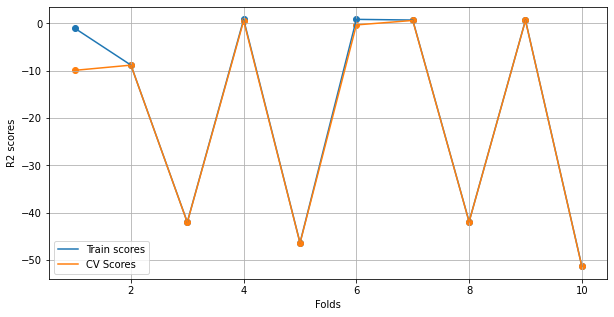

Best R2 score is  0.6173311847846967 and best hyperparameters is  {'subsample': 0.3, 'reg_alpha': 0.001, 'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.1}


In [137]:
model = XGBRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_corr_tsvd_xgb_model = ensemble(model,params,label_interaction_tsvd_train)

# Best model from the hyperparameter tuning
label_corr_tsvd_xgb_final = label_corr_tsvd_xgb_model.best_estimator_
label_corr_tsvd_xgb_final.fit(label_interaction_tsvd_train,y_train['y'].values)

# Final submission.csv for kaggle scores
label_corr_tsvd_submission = submission(label_corr_tsvd_xgb_final,label_interaction_tsvd_test)
save_model('label_corr_tsvd_xgb_final',label_corr_tsvd_xgb_final)

In [138]:
label_corr_tsvd_submission.to_csv('label_submission/label_corr_tsvd_xgb_submission.csv',index = False)

#### Mean Encoding

In [139]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


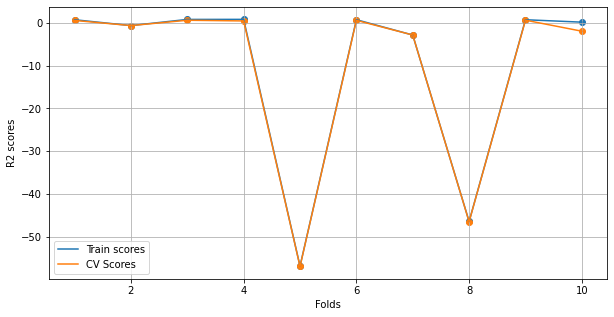

Best R2 score is  0.5942045229155168 and best hyperparameters is  {'subsample': 0.5, 'reg_alpha': 100, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.01, 'colsample_bytree': 1}


In [140]:
model = XGBRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_corr_tsvd_xgb_model = ensemble(model,params,mean_interaction_tsvd_train)

# Best model from the hyperparameter tuning
mean_corr_tsvd_xgb_final = mean_corr_tsvd_xgb_model.best_estimator_
mean_corr_tsvd_xgb_final.fit(mean_interaction_tsvd_train,y_train['y'].values)

# Final submission.csv for kaggle scores
mean_corr_tsvd_submission = submission(mean_corr_tsvd_xgb_final,mean_interaction_tsvd_test)
save_model('mean_corr_tsvd_xgb_final',mean_corr_tsvd_xgb_final)

In [141]:
mean_corr_tsvd_submission.to_csv('mean_submission/mean_corr_tsvd_xgb_submission.csv',index = False)

#### GLMM encoding

In [142]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


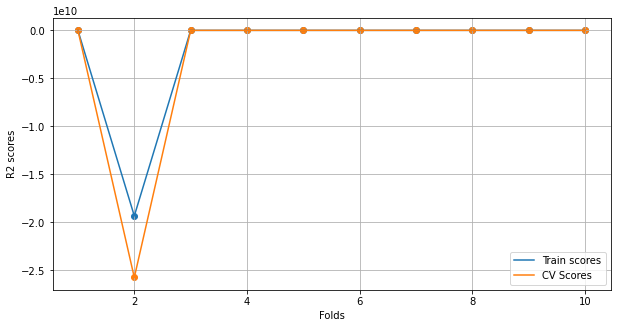

Best R2 score is  0.5997792418009654 and best hyperparameters is  {'subsample': 0.1, 'reg_alpha': 100, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.01, 'colsample_bytree': 0.1}


In [143]:
model = XGBRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_corr_tsvd_xgb_model = ensemble(model,params,glmm_interaction_tsvd_train)

# Best model from the hyperparameter tuning
glmm_corr_tsvd_xgb_final = glmm_corr_tsvd_xgb_model.best_estimator_
glmm_corr_tsvd_xgb_final.fit(glmm_interaction_tsvd_train,y_train['y'].values)

# Final submission.csv for kaggle scores
glmm_corr_tsvd_submission = submission(glmm_corr_tsvd_xgb_final,glmm_interaction_tsvd_test)
save_model('glmm_corr_tsvd_xgb_final',glmm_corr_tsvd_xgb_final)

In [144]:
glmm_corr_tsvd_submission.to_csv('glmm_submission/glmm_corr_tsvd_xgb_submission.csv',index = False)

### Stacked Models

#### I will be using stacked models of (Random Forest, XG bosst, Extra tree regresssor) on Label, Mean and GLMM encoding. Using Ridge as final meta regressor with regularization set to 0 so it doesn't impact stacked models. 

#### Label Encoding

In [145]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_label_corr_tsvd = StackingRegressor(estimators = [('rf',label_corr_tsvd_rf_final),('xgb',label_corr_tsvd_xgb_final),('et',label_corr_tsvd_et_final)],final_estimator = ridge,cv = 10,n_jobs = -1)
stack_label_corr_tsvd.fit(label_interaction_tsvd_train,y_train['y'].values)
                
# Final submission.csv for kaggle scores
label_submission = submission(stack_label_corr_tsvd,label_interaction_tsvd_test)
save_model('stack_label_corr_tsvd',stack_label_corr_tsvd)

In [146]:
label_submission.to_csv('label_submission/label_corr_tsvd_stack_submission.csv',index = False)

#### Mean Encoding

In [147]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_mean_corr_tsvd = StackingRegressor(estimators = [('rf',mean_corr_tsvd_rf_final),('xgb',mean_corr_tsvd_xgb_final),('et',mean_corr_tsvd_et_final)],final_estimator = ridge,cv = 10,n_jobs = -1)
stack_mean_corr_tsvd.fit(mean_interaction_tsvd_train,y_train['y'].values)
    
# Final submission.csv for kaggle scores
mean_submission = submission(stack_mean_corr_tsvd,mean_interaction_tsvd_test)
save_model('stack_mean_corr_tsvd',stack_mean_corr_tsvd)

In [148]:
mean_submission.to_csv('mean_submission/mean_corr_tsvd_stack_submission.csv',index = False)

#### Glmm Encoding

In [149]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_glmm_corr_tsvd = StackingRegressor(estimators = [('rf',glmm_corr_tsvd_rf_final),('xgb',glmm_corr_tsvd_xgb_final),('et',glmm_corr_tsvd_et_final)],final_estimator = ridge,cv = 10,n_jobs = -1)
stack_glmm_corr_tsvd.fit(glmm_interaction_tsvd_train,y_train['y'].values)
    
# Final submission.csv for kaggle scores
glmm_submission = submission(stack_glmm_corr_tsvd,glmm_interaction_tsvd_test)
save_model('stack_glmm_corr_tsvd',stack_glmm_corr_tsvd)

In [150]:
glmm_submission.to_csv('glmm_submission/glmm_corr_tsvd_stack_submission.csv',index = False)

## Leaderboard scores

In [156]:
from prettytable import PrettyTable
#Label Encoding
table = PrettyTable()
table.title = 'Label_Encoding + Interaction'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.53284','0.53196'])
table.add_row(['Random Forests','0.54454','0.54855'])
table.add_row(['Extra Trees Regressor','0.55241','0.55223'])
table.add_row(['XGboost','0.54591','0.55129'])
table.add_row(['Stacked','0.55059','0.55304'])
print(table)

table = PrettyTable()
table.title = 'Label_Encoding + Interaction + pca'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.53124','0.53112'])
table.add_row(['Random Forests','0.54809','0.55310'])
table.add_row(['Extra Trees Regressor','0.54744','0.54990'])
table.add_row(['XGboost','0.54237','0.54557'])
table.add_row(['Stacked','0.55036','0.55241'])
print(table)

table = PrettyTable()
table.title = 'Label_Encoding + Interaction + tsvd'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.53110','0.52954'])
table.add_row(['Random Forests','0.54771','0.55240'])
table.add_row(['Extra Trees Regressor','0.54773','0.54992'])
table.add_row(['XGboost','0.54395','0.54904'])
table.add_row(['Stacked','0.54935','0.55254'])
print(table)

+------------------------------------------------------+
|             Label_Encoding + Interaction             |
+-----------------------+---------------+--------------+
|         Model         | Private_Score | Public_Score |
+-----------------------+---------------+--------------+
|         Lasso         |    0.53284    |   0.53196    |
|     Random Forests    |    0.54454    |   0.54855    |
| Extra Trees Regressor |    0.55241    |   0.55223    |
|        XGboost        |    0.54591    |   0.55129    |
|        Stacked        |    0.55059    |   0.55304    |
+-----------------------+---------------+--------------+
+------------------------------------------------------+
|          Label_Encoding + Interaction + pca          |
+-----------------------+---------------+--------------+
|         Model         | Private_Score | Public_Score |
+-----------------------+---------------+--------------+
|         Lasso         |    0.53124    |   0.53112    |
|     Random Forests    |    0.

In [157]:
from prettytable import PrettyTable
#Mean Encoding
table = PrettyTable()
table.title = 'Mean_Encoding + Interaction'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.54327','0.55429'])
table.add_row(['Random Forests','0.54361','0.54904'])
table.add_row(['Extra Trees Regressor','0.54826','0.55240'])
table.add_row(['XGboost','0.54029','0.54732'])
table.add_row(['Stacked','0.54852','0.55340'])
print(table)

table = PrettyTable()
table.title = 'Mean_Encoding + Interaction + pca'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.54324','0.55444'])
table.add_row(['Random Forests','0.54352','0.54896'])
table.add_row(['Extra Trees Regressor','0.55258','0.55390'])
table.add_row(['XGboost','0.53658','0.54446'])
table.add_row(['Stacked','0.55202','0.55522'])
print(table)

table = PrettyTable()
table.title = 'Mean_Encoding + Interaction + tsvd'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.54305','0.55415'])
table.add_row(['Random Forests','0.54484','0.55063'])
table.add_row(['Extra Trees Regressor','0.54839','0.55224'])
table.add_row(['XGboost','0.54009','0.54897'])
table.add_row(['Stacked','0.54969','0.55526'])
print(table)

+------------------------------------------------------+
|             Mean_Encoding + Interaction              |
+-----------------------+---------------+--------------+
|         Model         | Private_Score | Public_Score |
+-----------------------+---------------+--------------+
|         Lasso         |    0.54327    |   0.55429    |
|     Random Forests    |    0.54361    |   0.54904    |
| Extra Trees Regressor |    0.54826    |   0.55240    |
|        XGboost        |    0.54029    |   0.54732    |
|        Stacked        |    0.54852    |   0.55340    |
+-----------------------+---------------+--------------+
+------------------------------------------------------+
|          Mean_Encoding + Interaction + pca           |
+-----------------------+---------------+--------------+
|         Model         | Private_Score | Public_Score |
+-----------------------+---------------+--------------+
|         Lasso         |    0.54324    |   0.55444    |
|     Random Forests    |    0.

In [158]:
from prettytable import PrettyTable
#GLMM Encoding
table = PrettyTable()
table.title = 'Glmm_Encoding + Interaction'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.54304','0.54691'])
table.add_row(['Random Forests','0.54365','0.54898'])
table.add_row(['Extra Trees Regressor','0.54886','0.55358'])
table.add_row(['XGboost','0.54025','0.54920'])
table.add_row(['Stacked','0.54796','0.55048'])
print(table)

table = PrettyTable()
table.title = 'Glmm_Encoding + Interaction + pca'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.54302','0.54699'])
table.add_row(['Random Forests','0.54349','0.54902'])
table.add_row(['Extra Trees Regressor','0.54257','0.54926'])
table.add_row(['XGboost','0.54449','0.55091'])
table.add_row(['Stacked','0.54929','0.55472'])
print(table)

table = PrettyTable()
table.title = 'Glmm_Encoding + Interaction + tsvd'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.54292','0.54686'])
table.add_row(['Random Forests','0.54355','0.54896'])
table.add_row(['Extra Trees Regressor','0.54743','0.55165'])
table.add_row(['XGboost','0.52337','0.52982'])
table.add_row(['Stacked','0.54764','0.55167'])
print(table)

+------------------------------------------------------+
|             Glmm_Encoding + Interaction              |
+-----------------------+---------------+--------------+
|         Model         | Private_Score | Public_Score |
+-----------------------+---------------+--------------+
|         Lasso         |    0.54304    |   0.54691    |
|     Random Forests    |    0.54365    |   0.54898    |
| Extra Trees Regressor |    0.54886    |   0.55358    |
|        XGboost        |    0.54025    |   0.54920    |
|        Stacked        |    0.54796    |   0.55048    |
+-----------------------+---------------+--------------+
+------------------------------------------------------+
|          Glmm_Encoding + Interaction + pca           |
+-----------------------+---------------+--------------+
|         Model         | Private_Score | Public_Score |
+-----------------------+---------------+--------------+
|         Lasso         |    0.54302    |   0.54699    |
|     Random Forests    |    0.

# Conclusion

1. From the above scores the Best performance was provided by Extra Trees Regressor on Mean Encoding with Interaction and PCA features added with a score of 0.55258 on private leaderboard on Kagggle.
2. As we can see that the second best model was Extra trees regressor on Label Encoding with Interaction features added. It got score of 0.55241 on private leaderboard of kaggle.
3. We can see that the Mean encoding worked better than Label encoding and GLMM encoding did not work well.
4. From the plots we can see that Interaction features has high importance in all the plots and X314,X315,X47 combination has top feature importance no matter which encoding we used.
4. The PCA components performed better with Mean encoding rather than Label and GLMM.
5. The best score on Kaggle 0.55258 give me a position of 102 on private leader board and in Top 10% scores.